In [1]:
import glob
import numpy as np
print('numpy version: ', np.__version__)
import astropy
print('astropy version: ', astropy.__version__)
from astropy.io import fits
from astropy import wcs
import asdf
print('asdf version: ', asdf.__version__)
import gwcs
print('gwcs version: ', gwcs.__version__)
import jwst
print('jwst version: ', jwst.__version__)

numpy version:  1.14.2
astropy version:  3.1.dev21789
asdf version:  2.1.0.dev1388
gwcs version:  0.9.dev329
jwst version:  0.9.3a.dev161+g1652b4f7


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from jwst import datamodels
from jwst.assign_wcs import nirspec

In [4]:
#!/Users/dencheva/dev/jwst/scripts/strun assign_wcs.cfg ifu.fits

In [5]:
im = datamodels.ImageModel('ifu_assign_wcs.fits')
wcs_00 = nirspec.nrs_wcs_set_input(im, 0)
print(wcs_00.available_frames)

['detector', 'sca', 'gwa', 'slit_frame', 'slicer', 'msa_frame']


### Tilt Correction:

In [6]:
print("ESA Trace file:", fits.getval("./esa/Trace_IFU_Slice_00_SMOS-MOD-G1M-17-5344175105_30192_JLAB88.fits", keyword="THETAY"))
print("Pipeline correction: {0} arcsec".format(3.965144262312808e-13 * 3600))

ESA Trace file: 1.42745193443261e-09
Pipeline correction: 1.4274519344326109e-09 arcsec


### Test 1

For each Trace file:
- Compute the pixel indices (x, y) for values in the SLIT extension that are between -0.5 and 0.5 (within the slit).
- Get the wavelength values for these pixels from the LAMBDA1 extension, the y-slit positions from the SLIT1 extension and teh MSa positions from the MSAY1 and MSAX1 extensions.
- Transfer these (x, y) to full frame coordinates using the FITS WCS in the Trace file.
- Evaluate the pipeline WCS passing these x, y as input to obtain ra, dec, lam from the pipeline code.
- Compute the difference between the ESA and pipeline wavelengths for these x, y pixels.
- Compute the difference in the y_slit position and MSAY positions

In [7]:
# Create a list of all TRACE* files from ESA. The files are expected to be in the a subdirectory called "esa".
esa = glob.glob("esa/*.fits")

In [8]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res

** Testing - relative wavelength difference **

2018-04-28 09:59:58,830 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide

2018-04-28 10:00:29,927 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



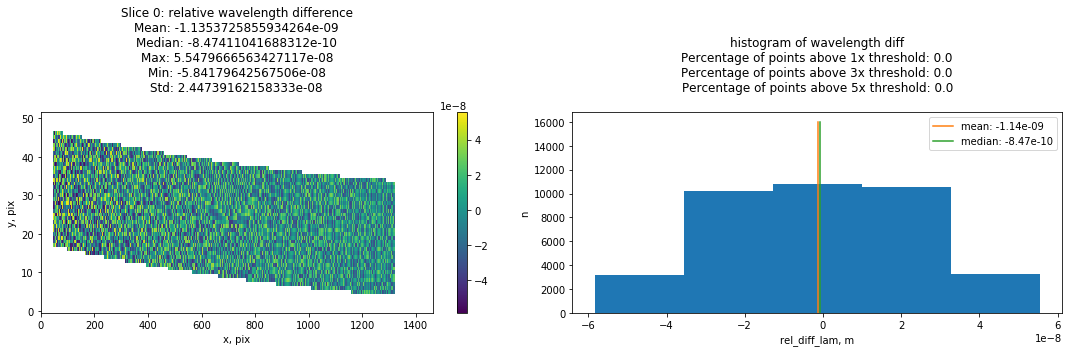

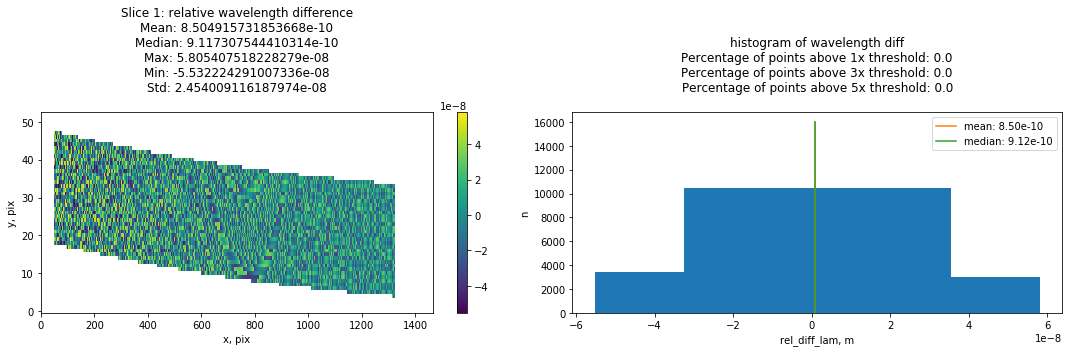

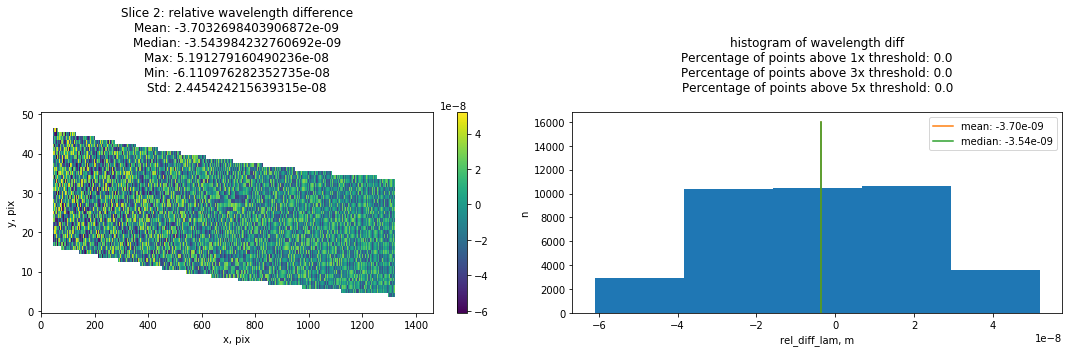

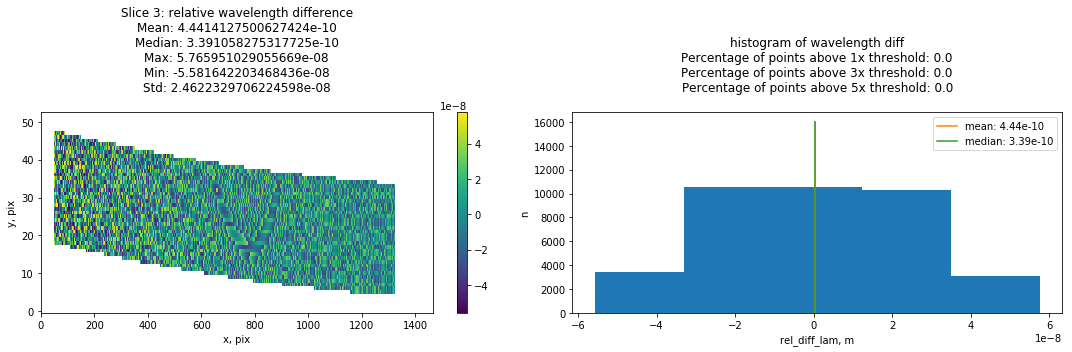

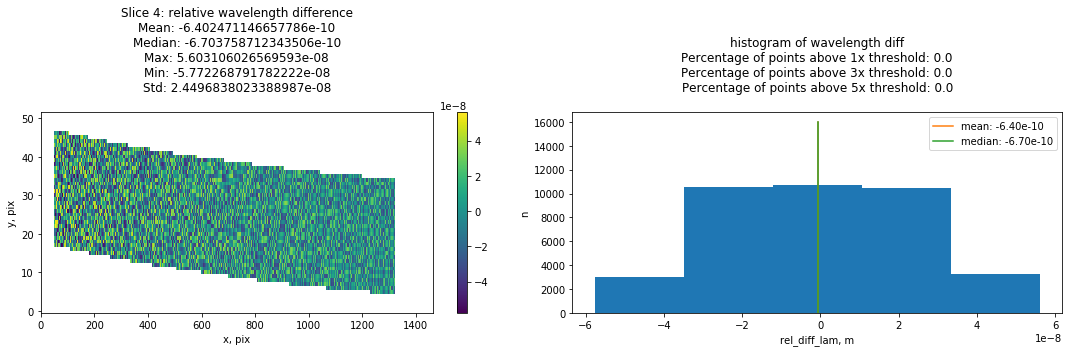

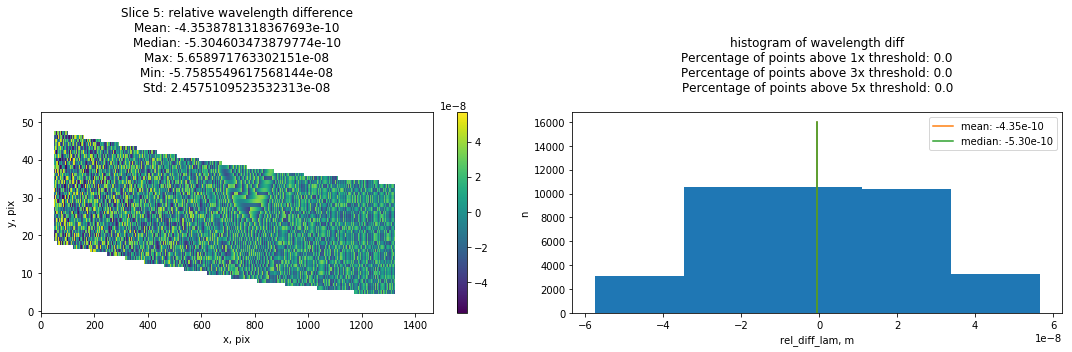

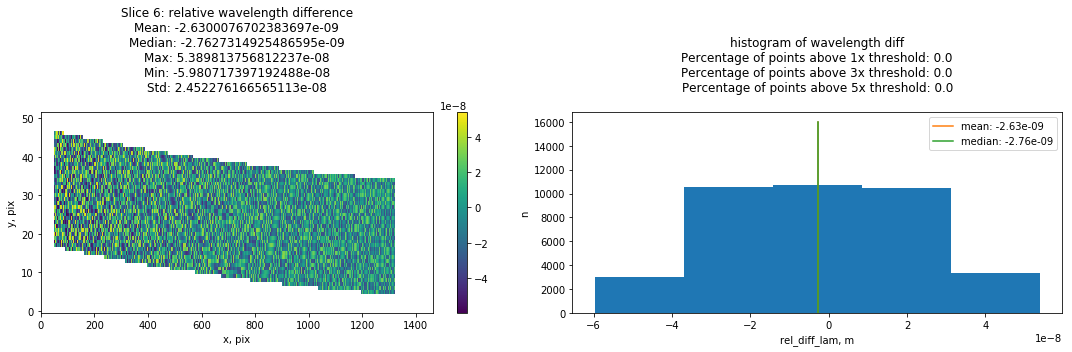

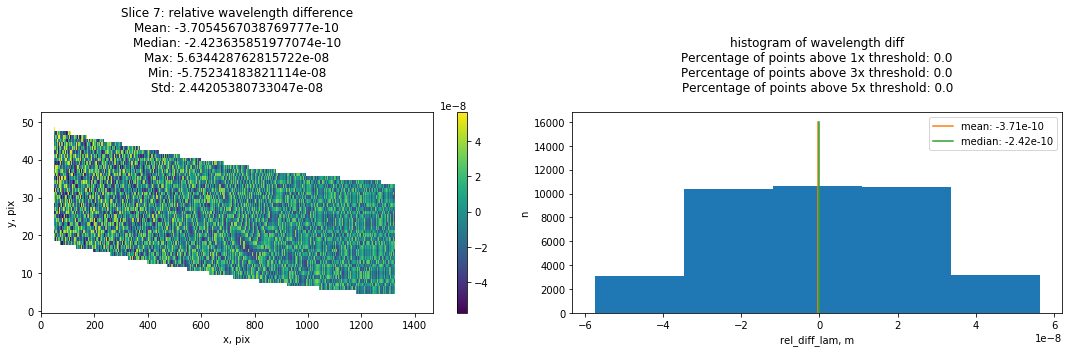

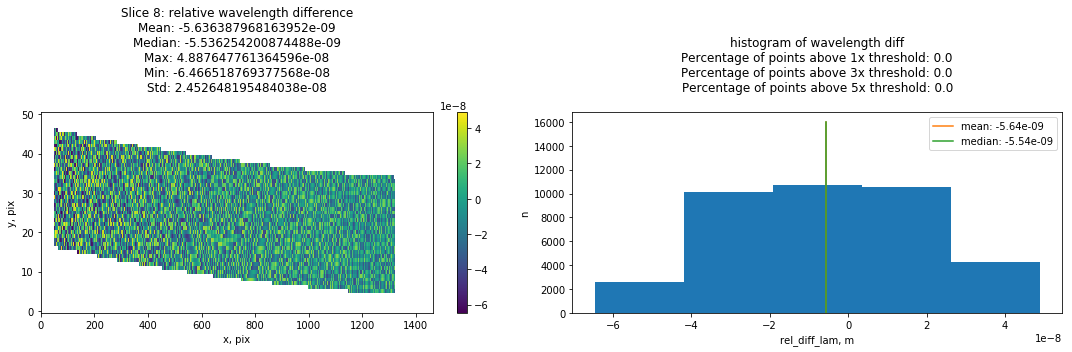

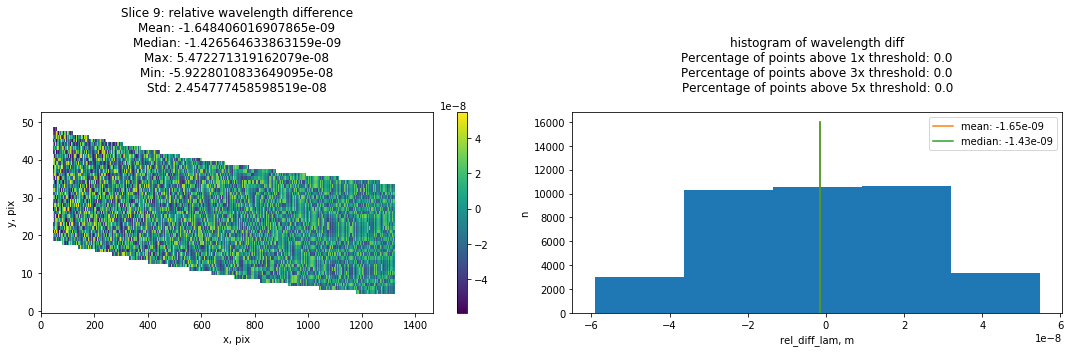

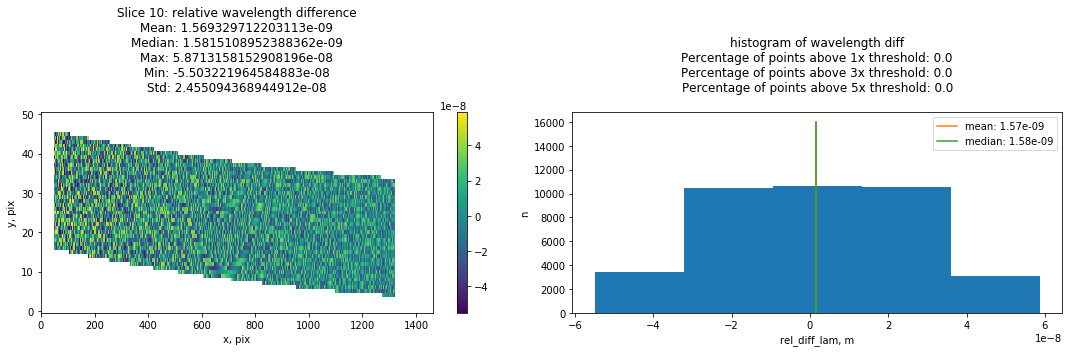

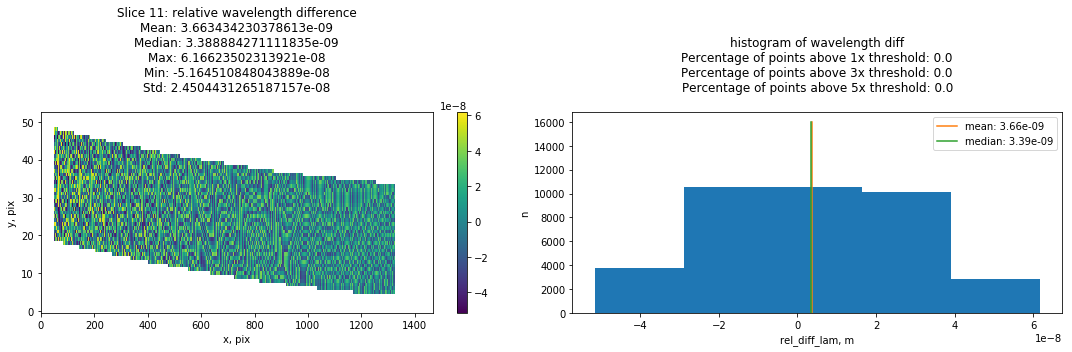

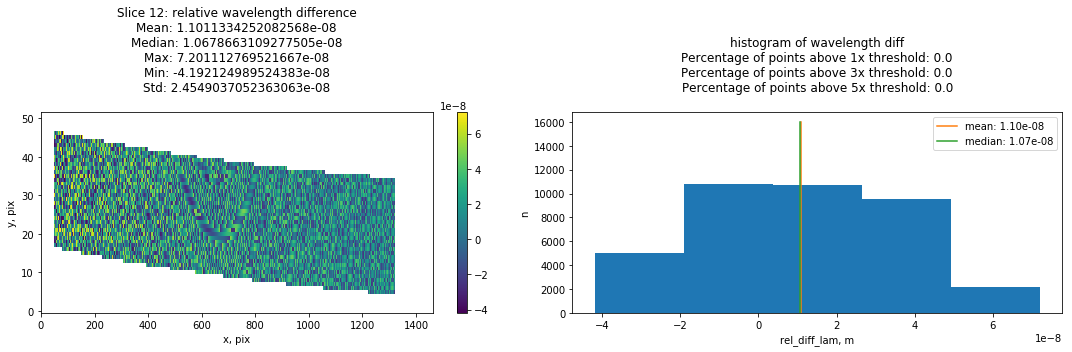

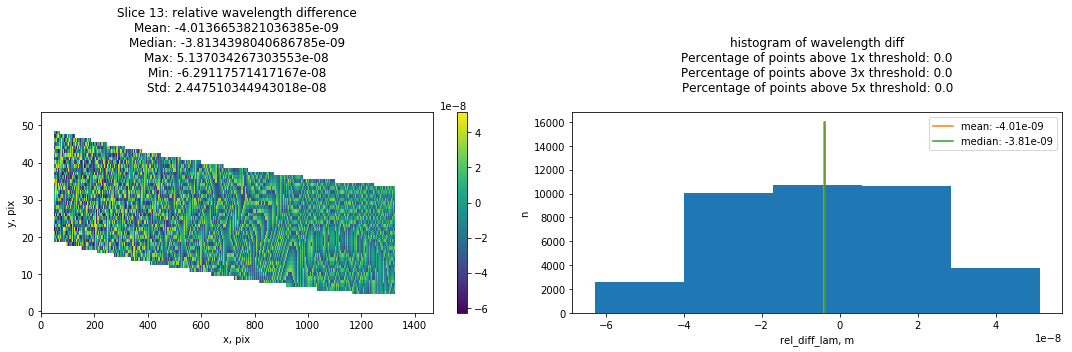

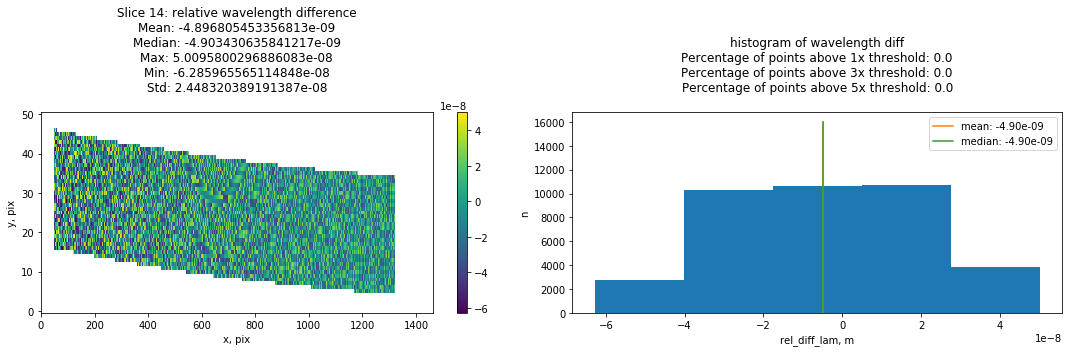

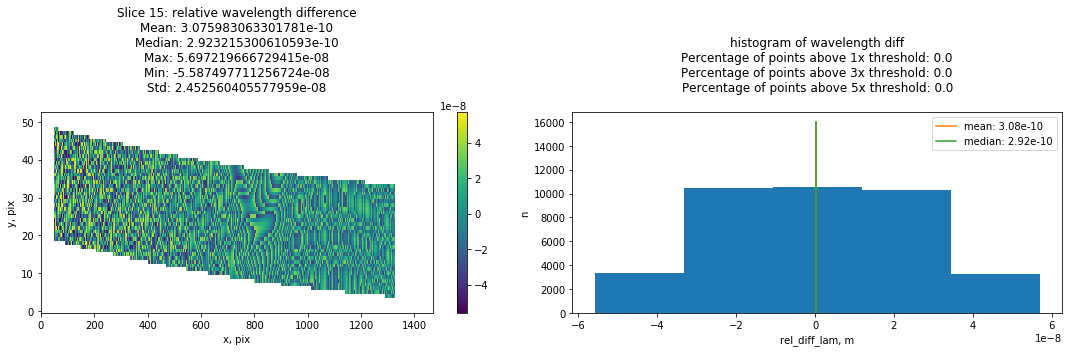

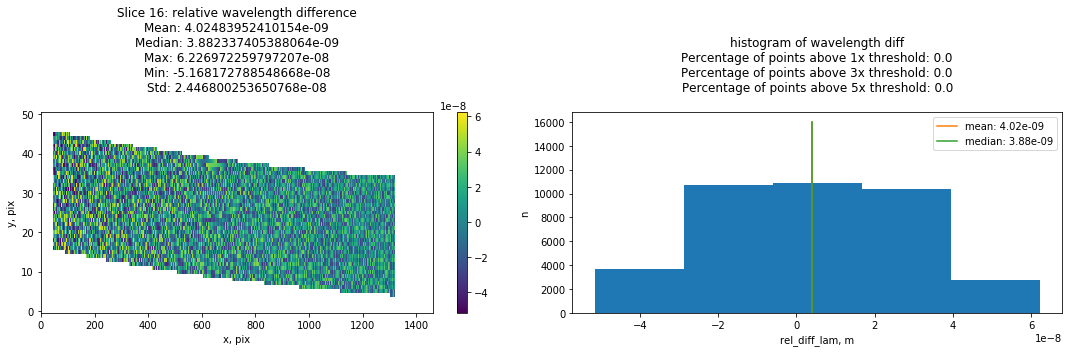

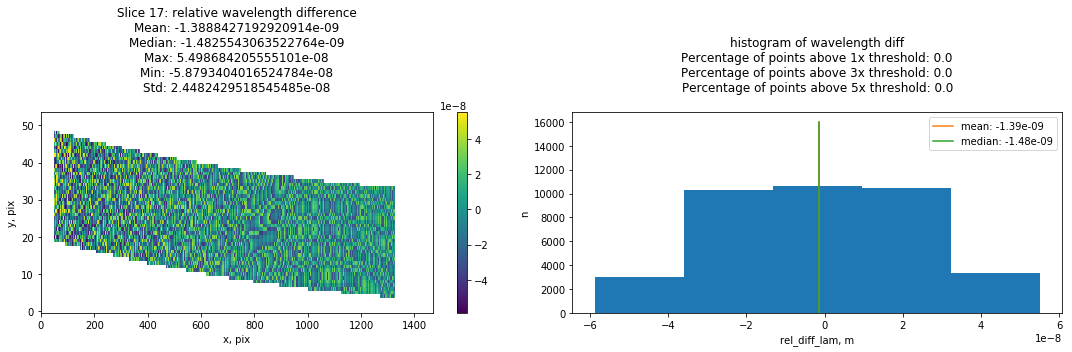

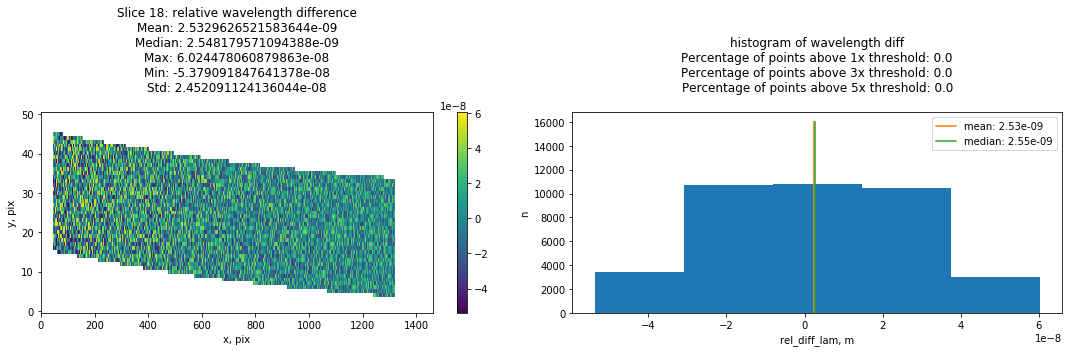

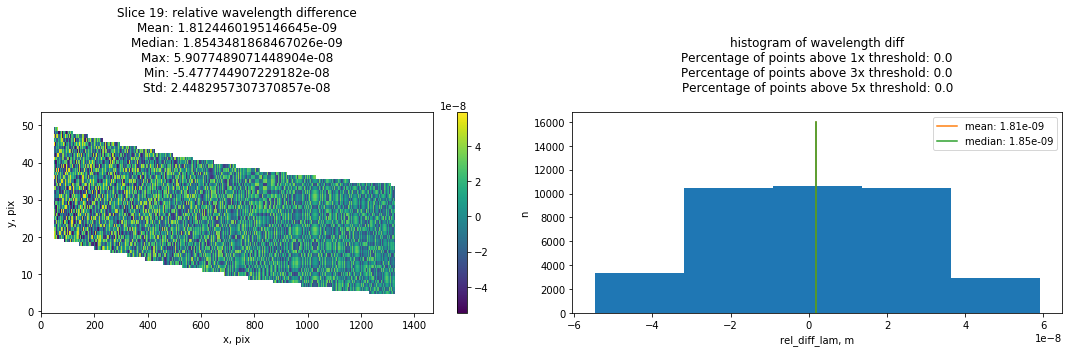

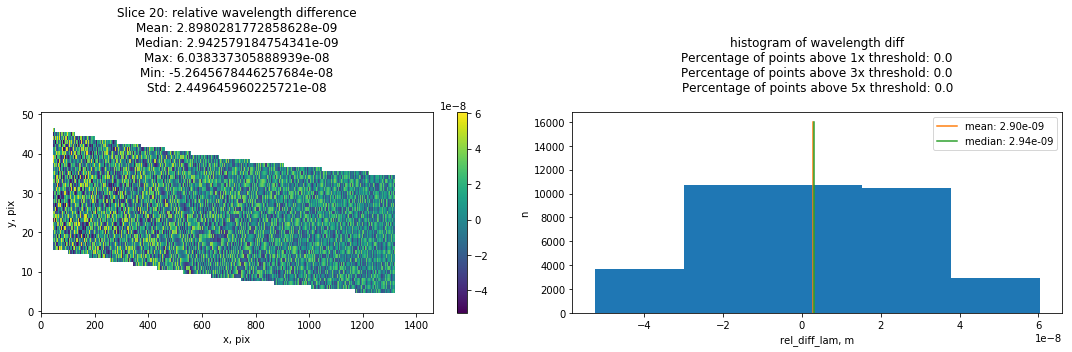

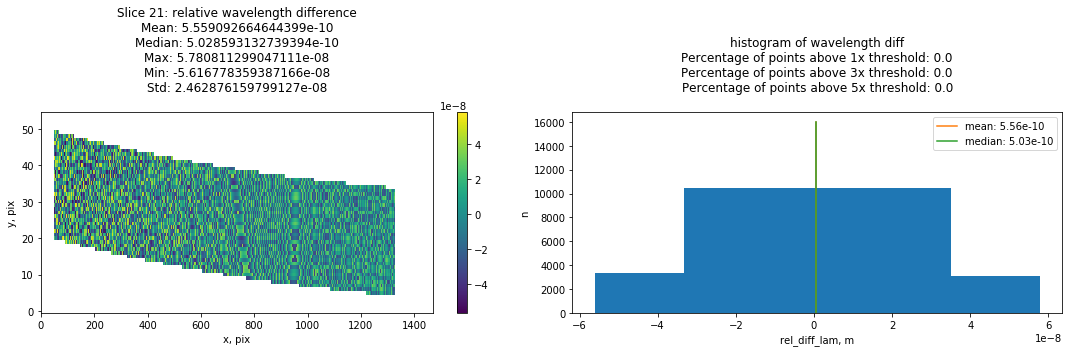

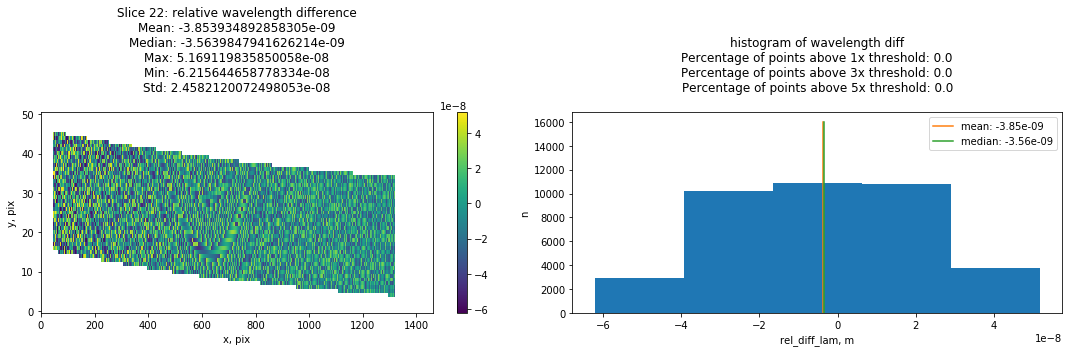

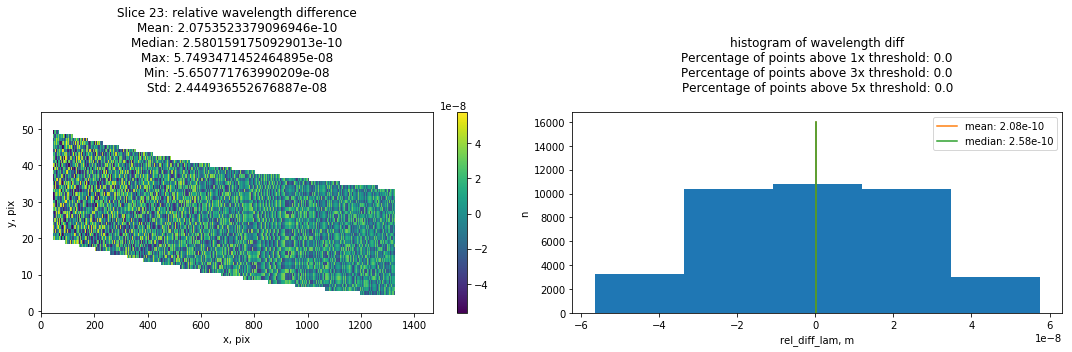

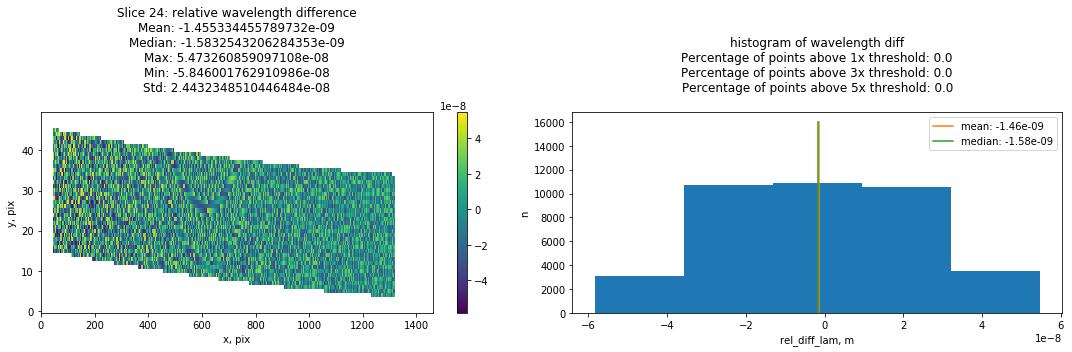

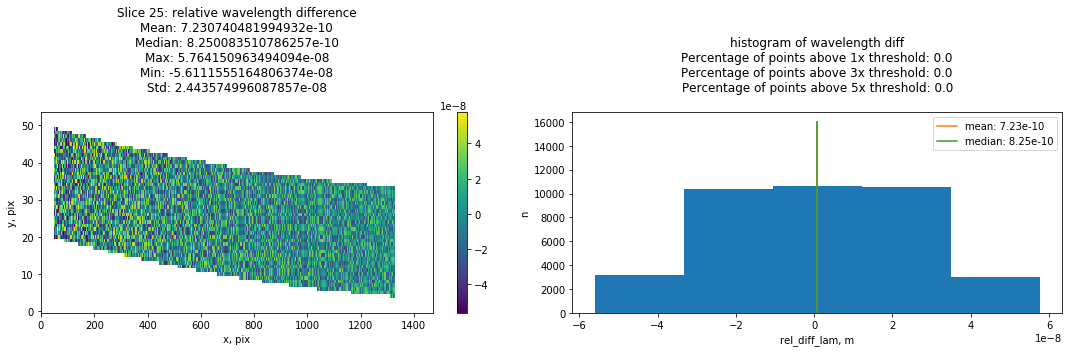

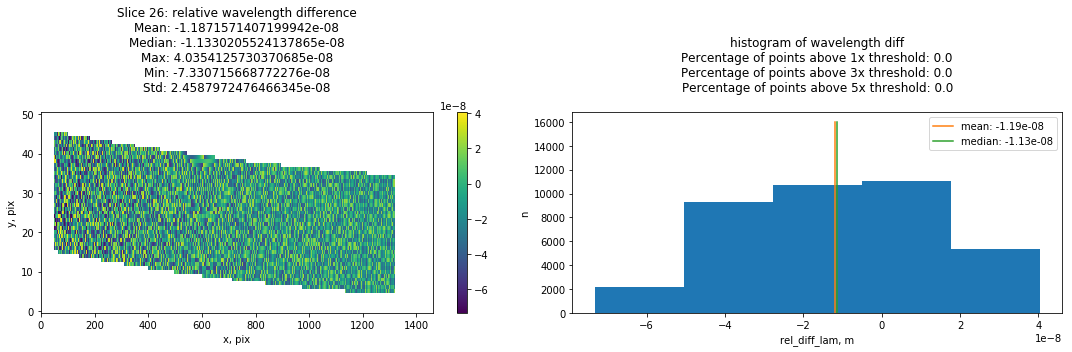

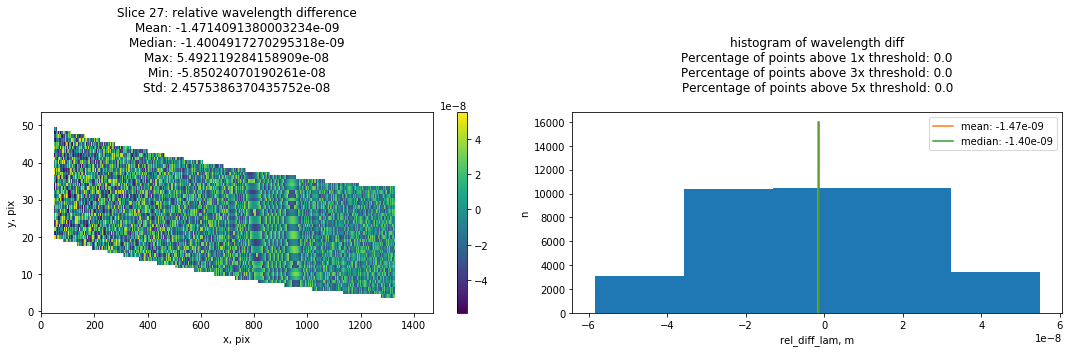

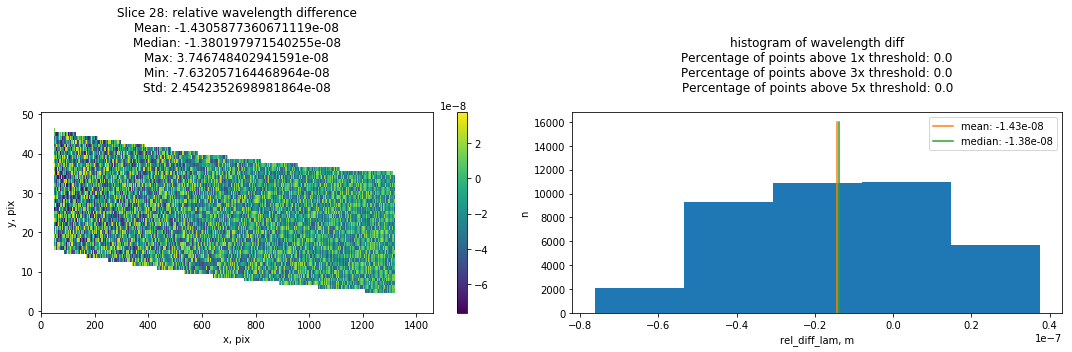

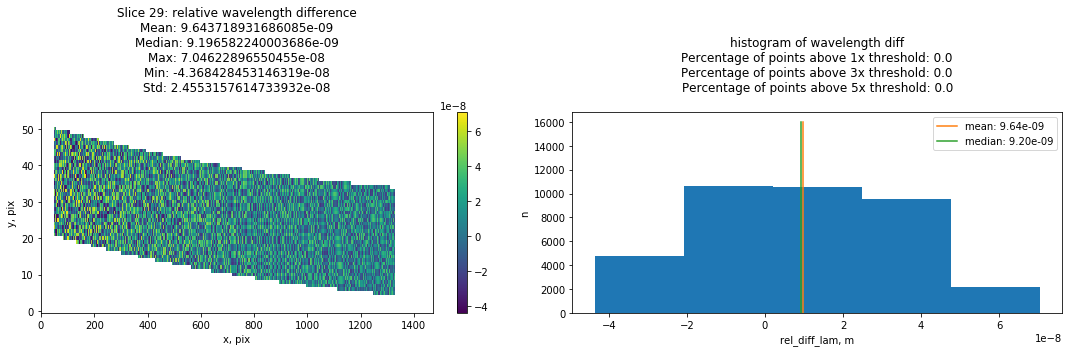

In [9]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr['LAMBDA1'].data
    slit1 = tr[5].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    # Compute ra, dec and lambda
    ra, dec, lam = wcs_slice(x1-1, y1-1) # move to 0-based coordinates
    lam *= 10**-6
    
    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    lam[~in_slit] = np.nan
    nanind = np.isnan(lam)
    notnan = ~nanind
    
    # Compute the difference in wavelength
    rel_diff_lam = (lam - lam1) / lam1
    
    # Compute statistics for notnan indices
    mean = np.mean(rel_diff_lam[notnan])
    median = np.median(rel_diff_lam[notnan])
    dmax = np.max(rel_diff_lam[notnan])
    dmin = np.min(rel_diff_lam[notnan])
    dstd = np.std(rel_diff_lam[notnan])
    percentage_results = compute_percentage(rel_diff_lam, 1e-7)
    
    title1 = "Slice {}: relative wavelength difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of wavelength diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])

    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(rel_diff_lam, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(rel_diff_lam[~np.isnan(rel_diff_lam)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('rel_diff_lam, m')
    plt.ylabel('n')
    fig.tight_layout()

** Slit-y positions **

2018-04-28 10:01:23,127 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



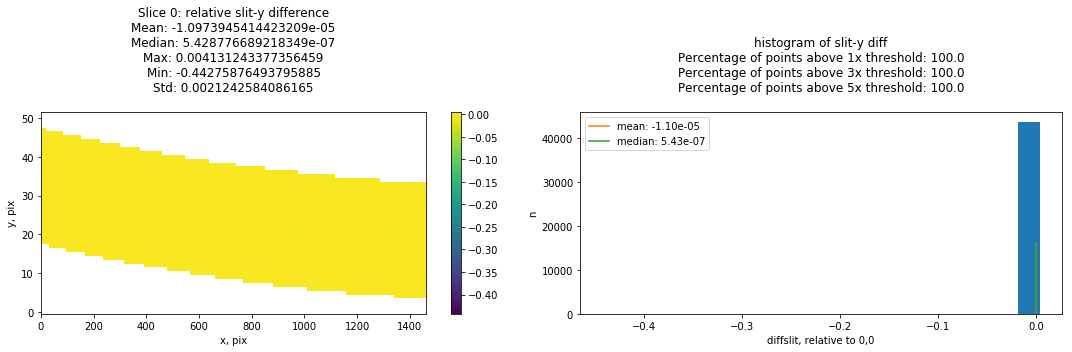

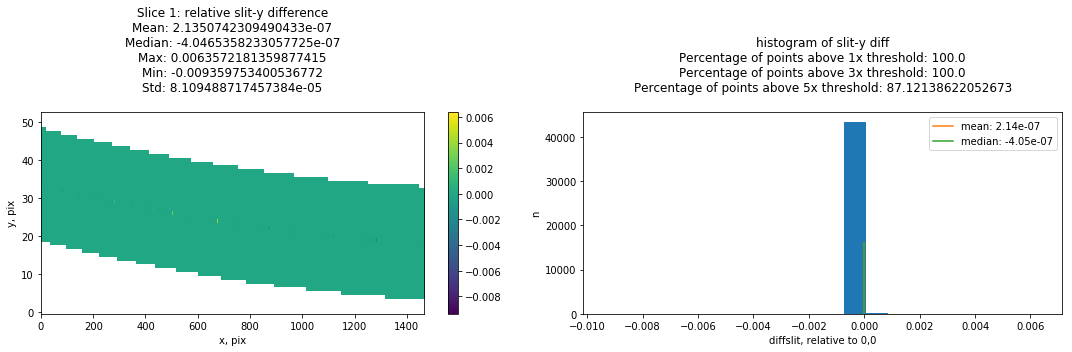

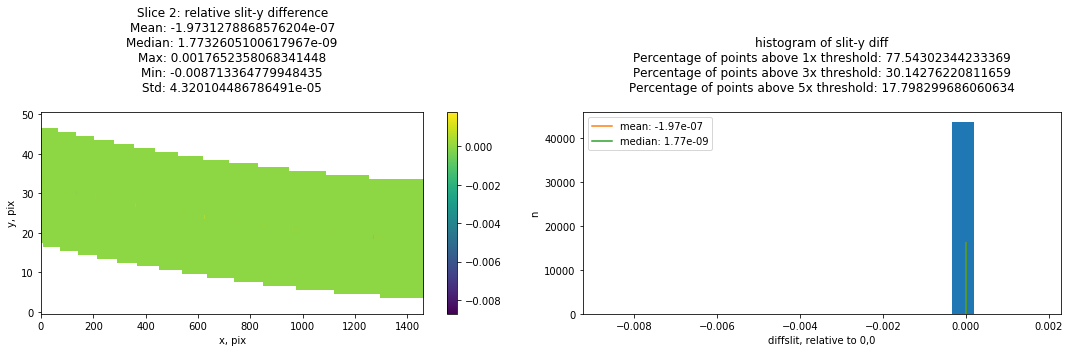

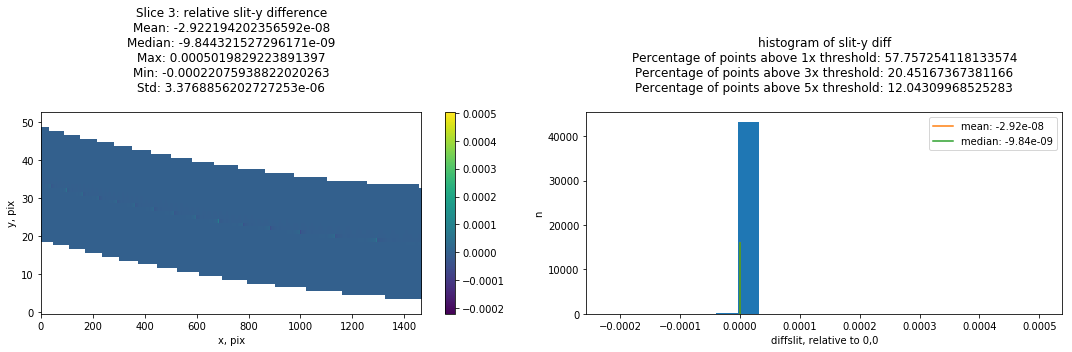

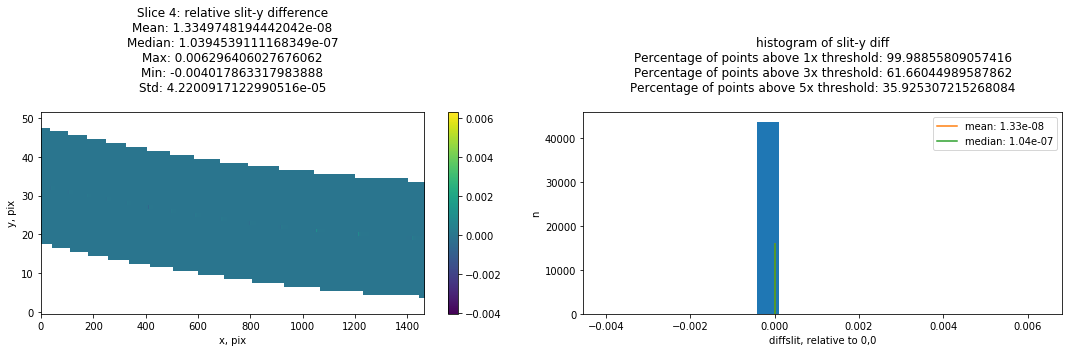

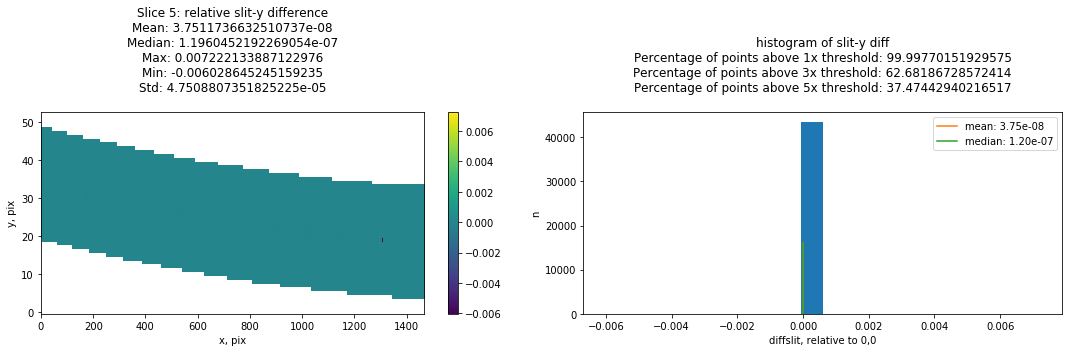

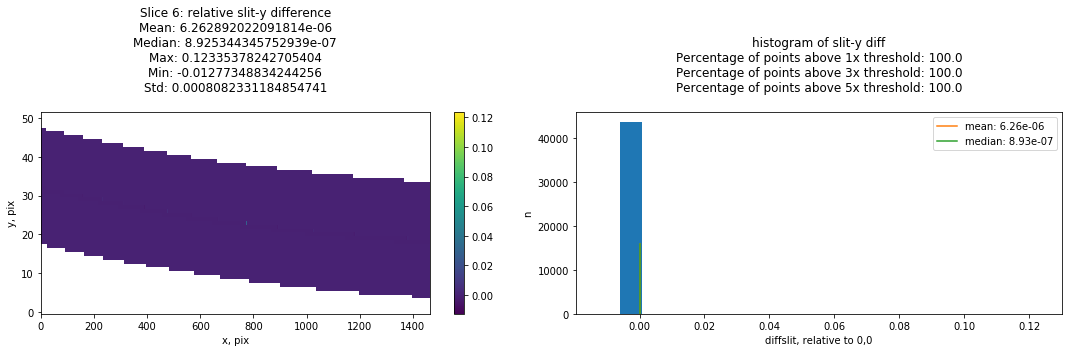

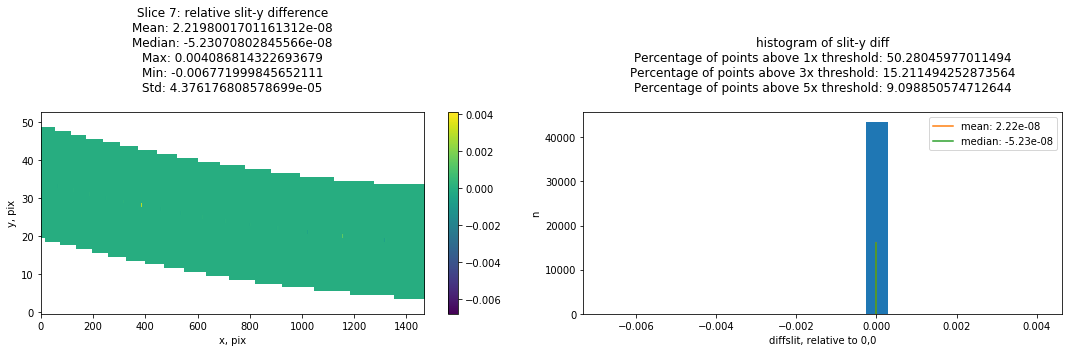

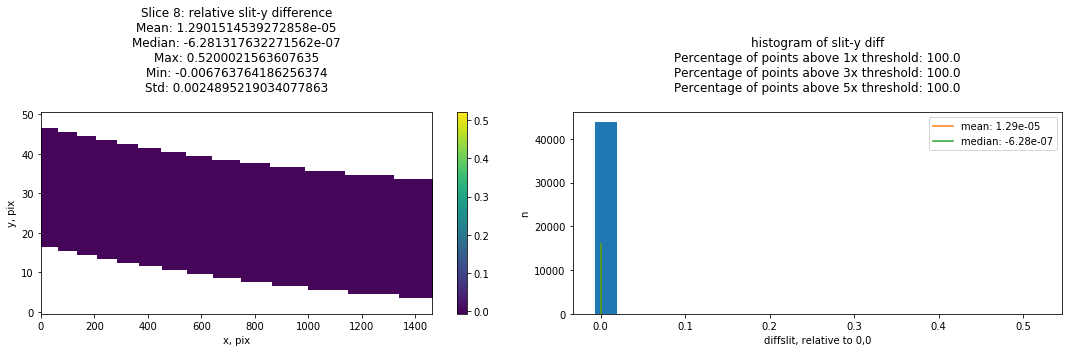

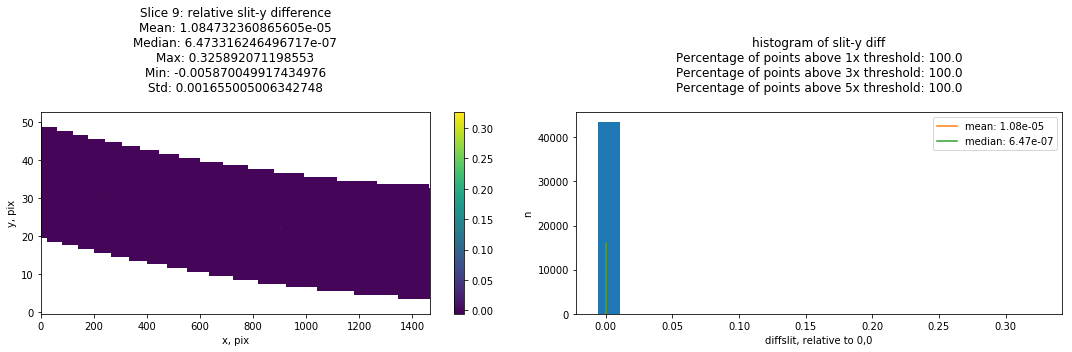

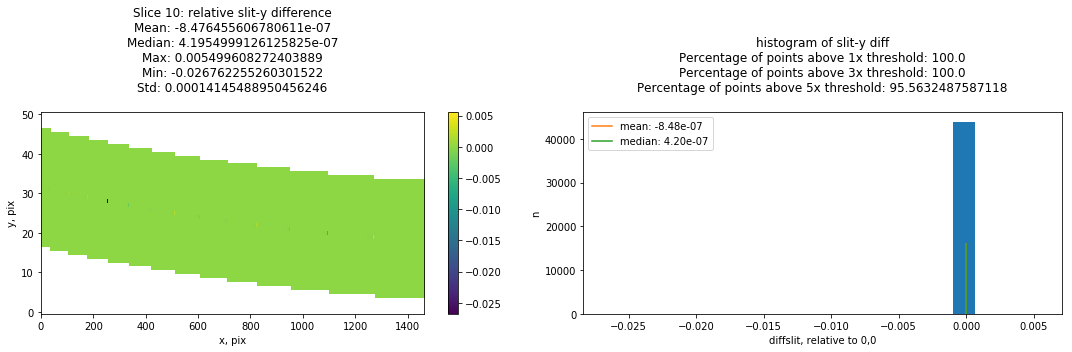

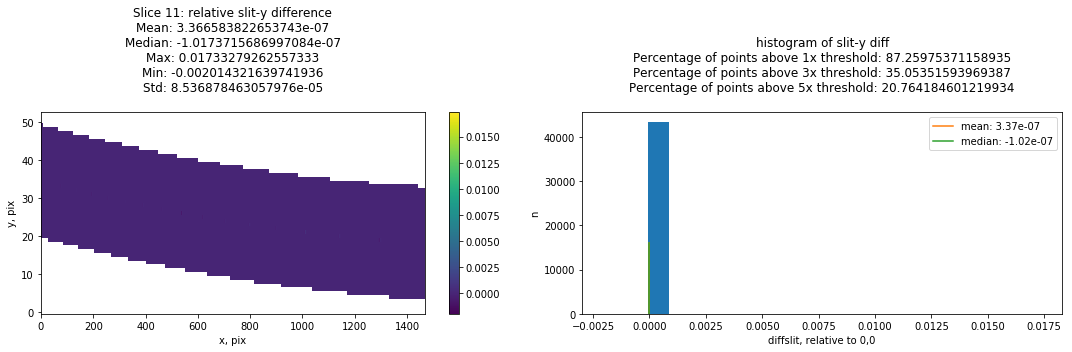

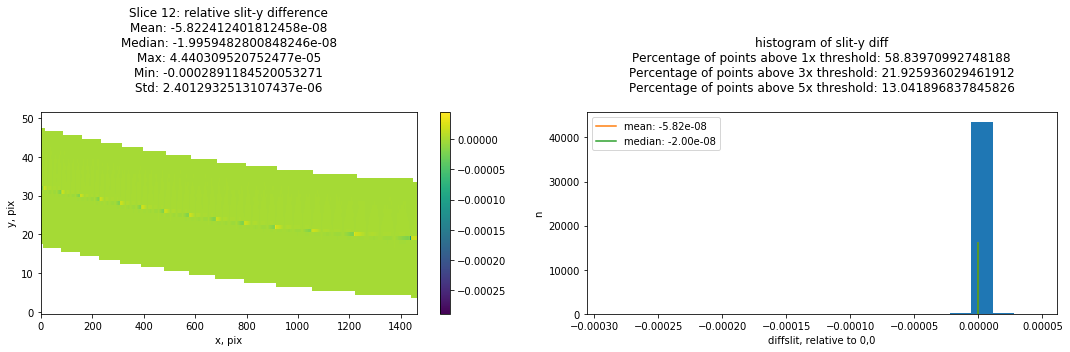

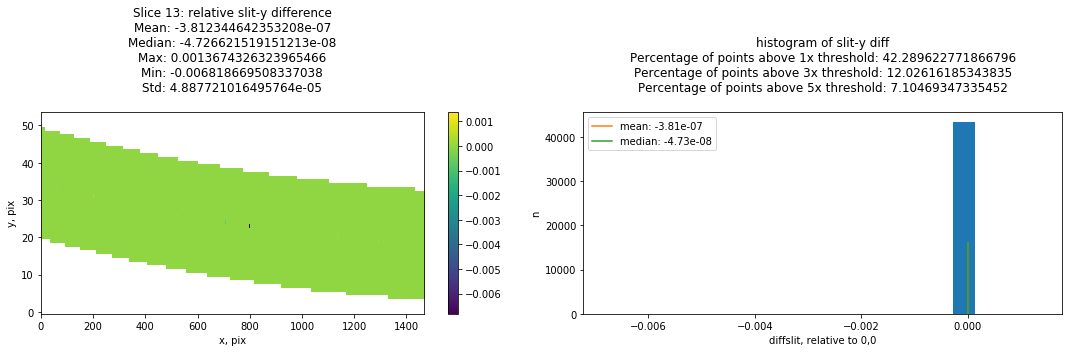

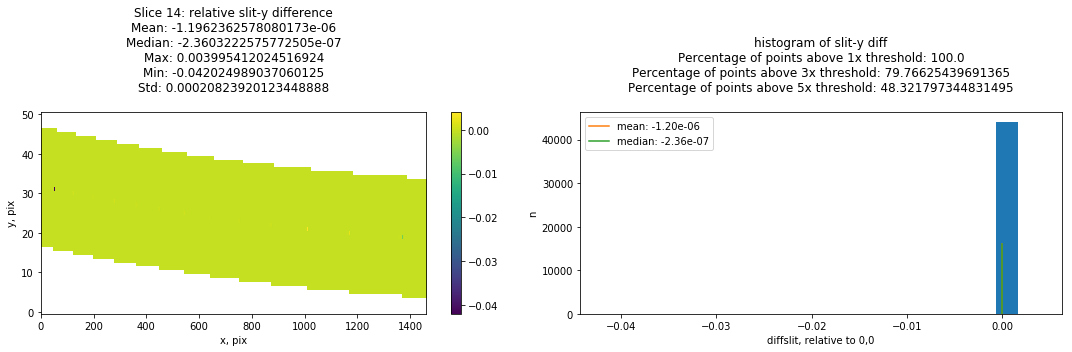

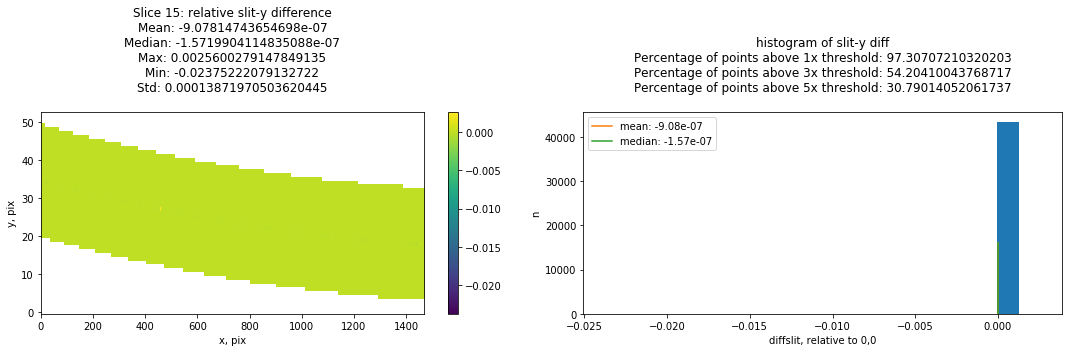

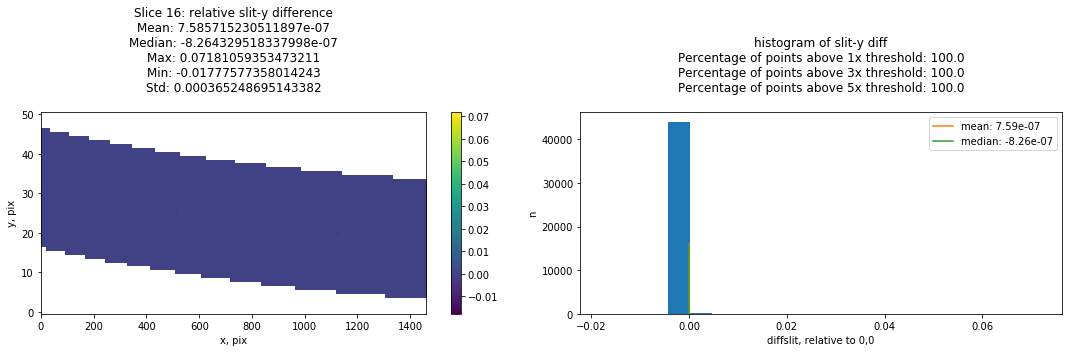

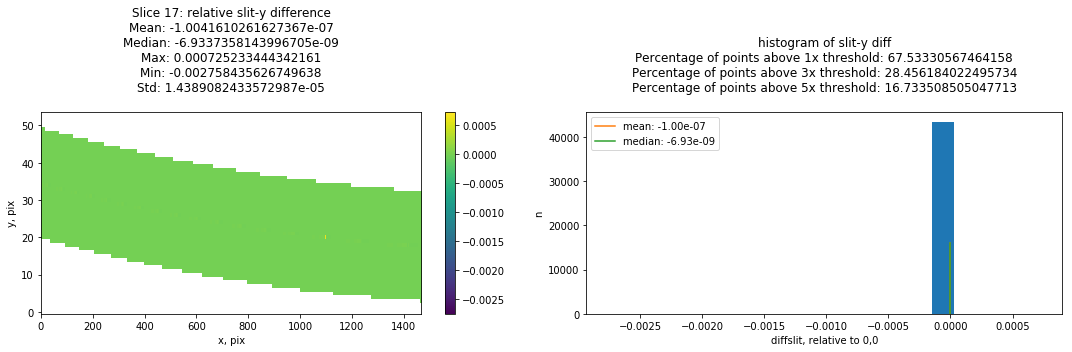

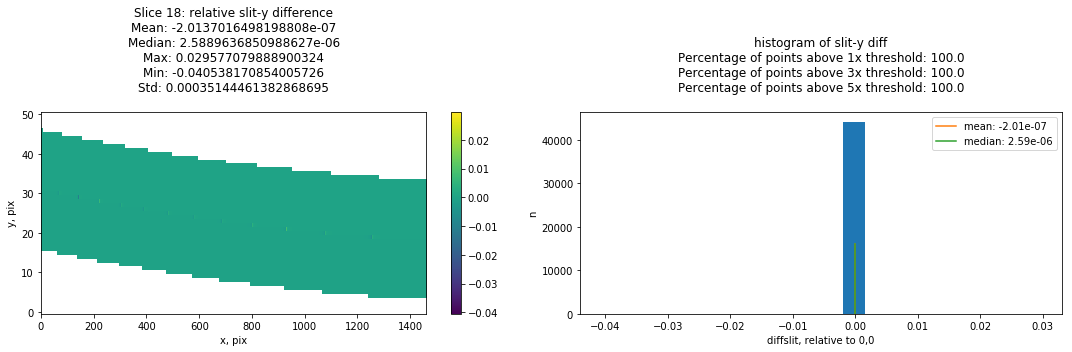

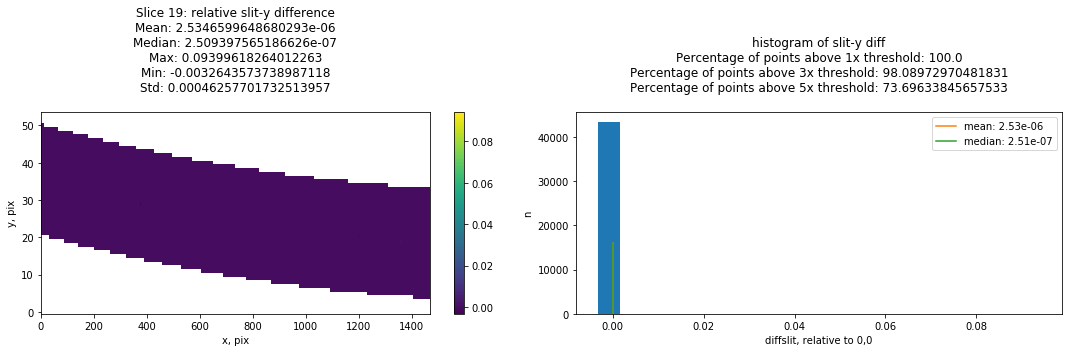

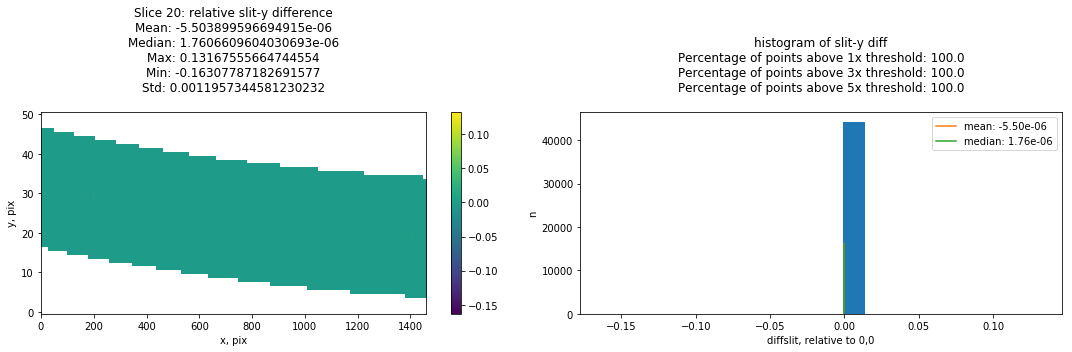

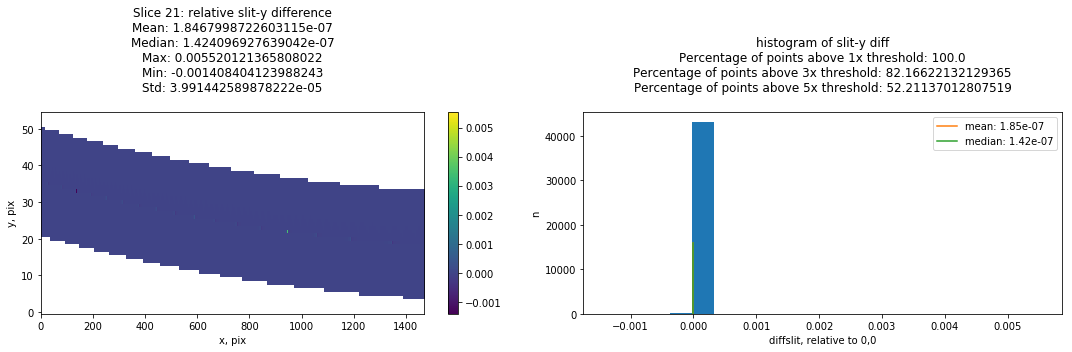

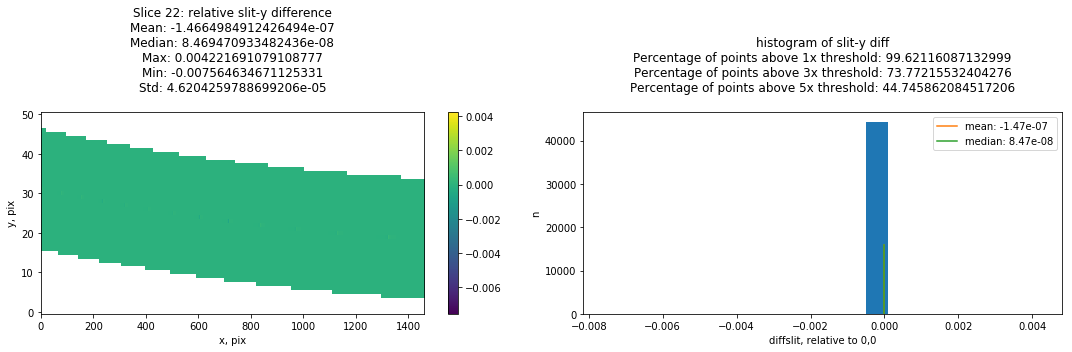

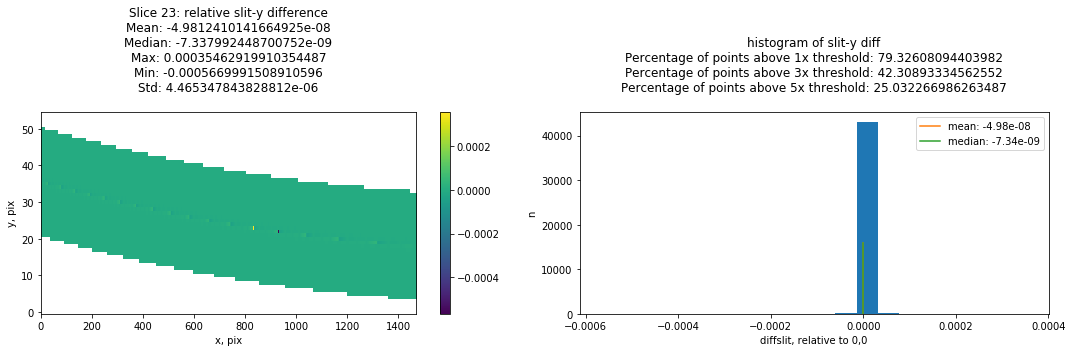

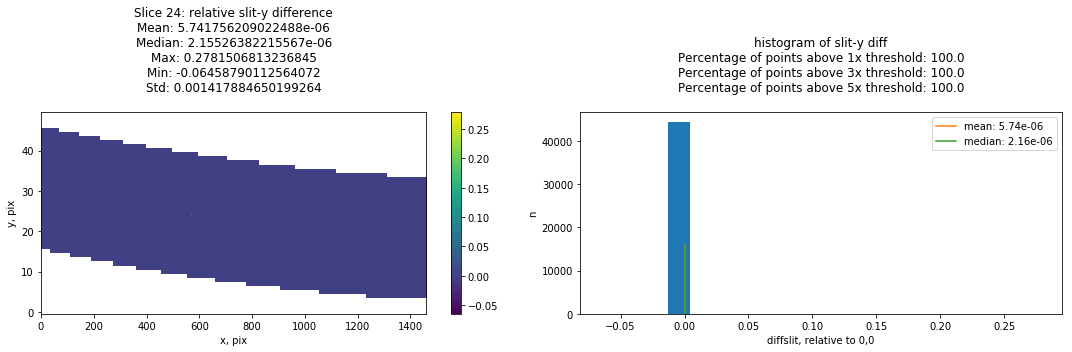

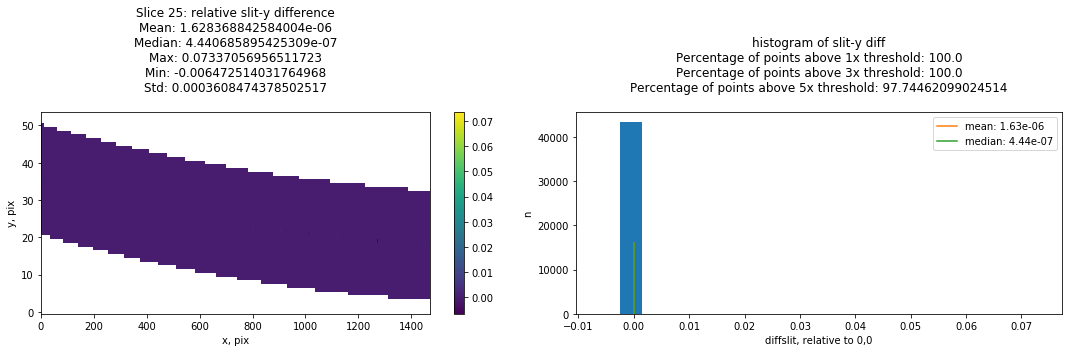

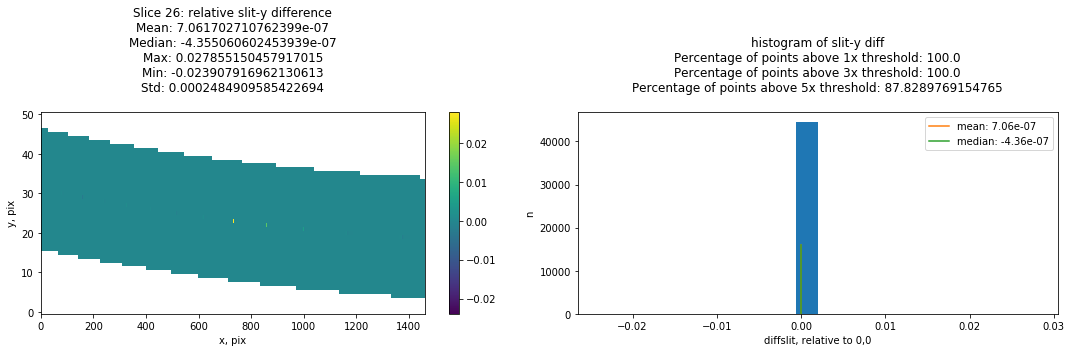

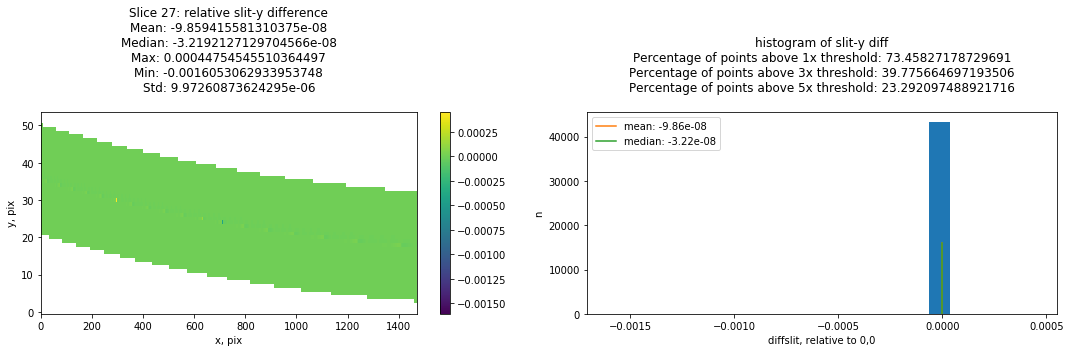

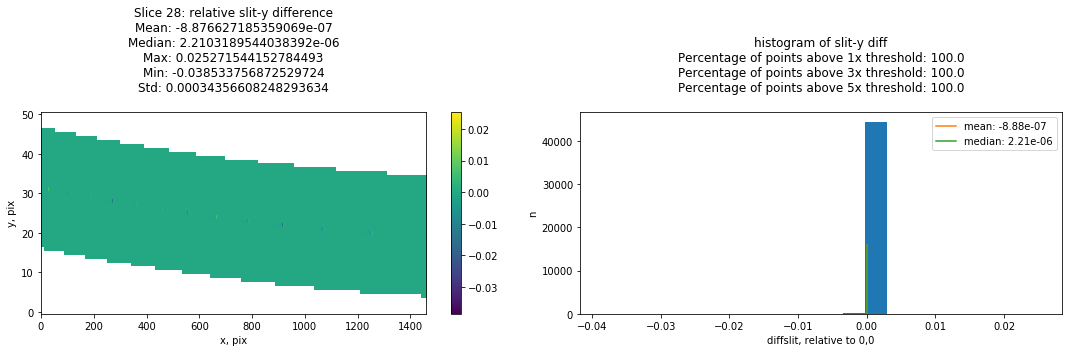

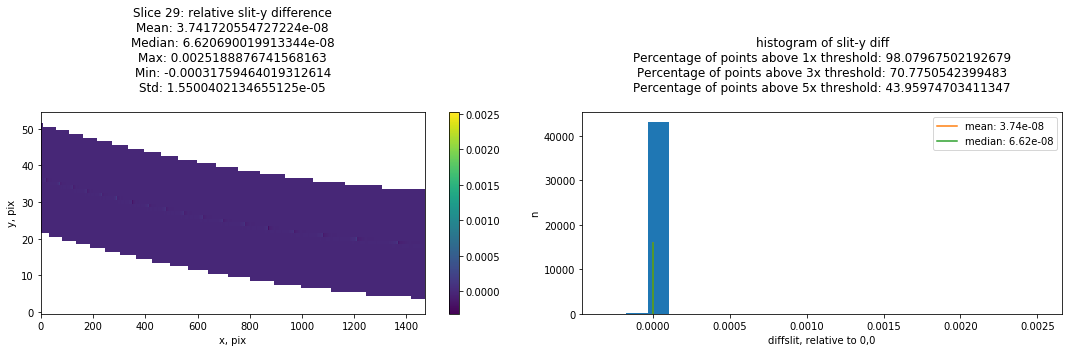

In [10]:
for trace in esa:
    # Open the Trace file and ead the extensions
    tr = fits.open(trace)
    #tr.info()
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)
    
    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    # Compute the difference in slit-y positions
    detector2slit = wcs_slice.get_transform("detector", "slit_frame")
    sx, sy, lam = detector2slit(x1-1, y1-1)
    
    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    sy[~in_slit] = np.nan
    nanind = np.isnan(sy)
    notnan = ~nanind
    
    diffslit = (sy - slit1) / slit1
    percentage_results = compute_percentage(diffslit, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffslit[notnan])
    median = np.median(diffslit[notnan])
    dmax = np.max(diffslit[notnan])
    dmin = np.min(diffslit[notnan])
    dstd = np.std(diffslit[notnan])
    
    title1 = "Slice {}: relative slit-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of slit-y diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffslit, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffslit[~np.isnan(diffslit)].flatten(), bins=20)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffslit, relative to 0,0')
    plt.ylabel('n')
    fig.tight_layout()

** MSA-y position **

2018-04-28 10:02:17,406 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



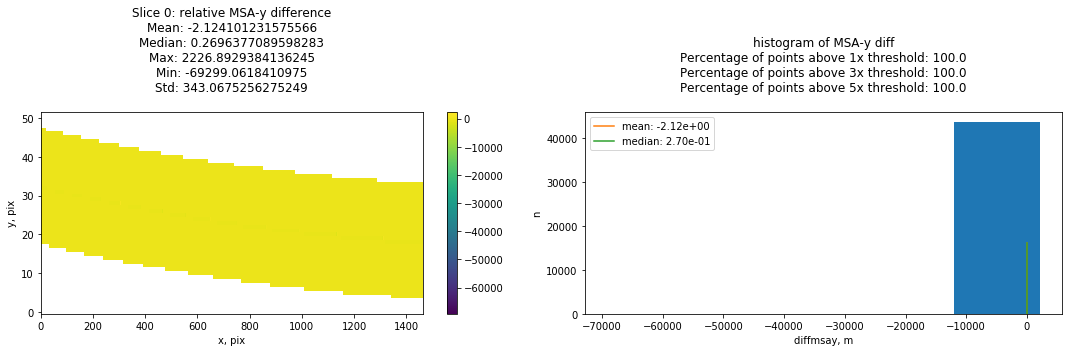

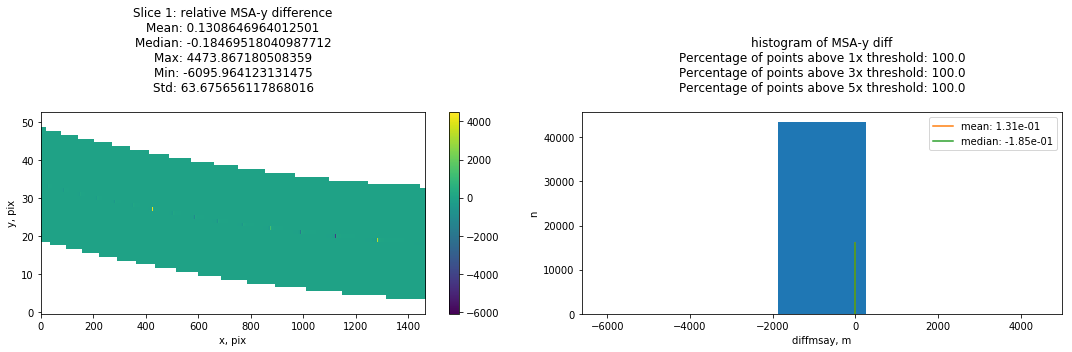

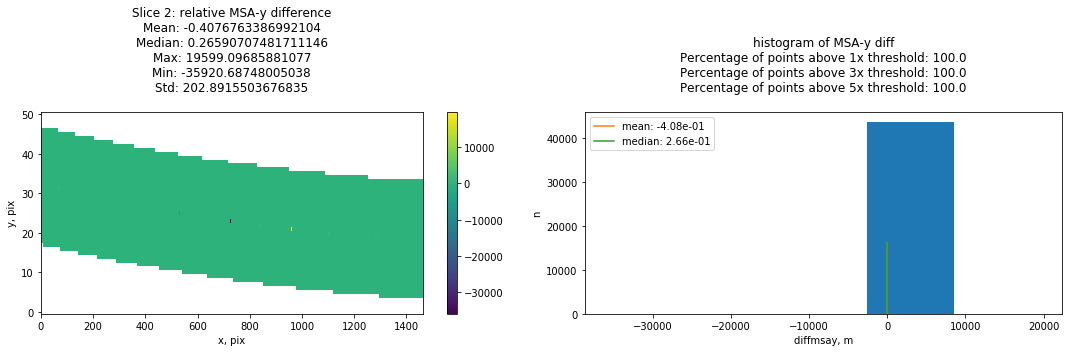

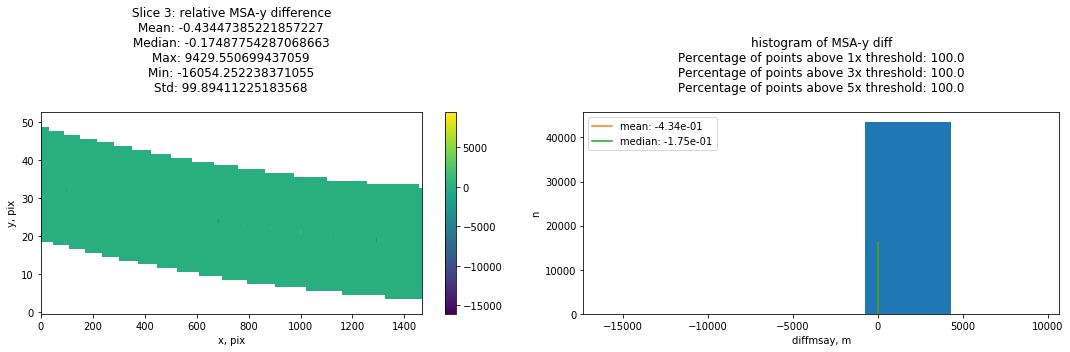

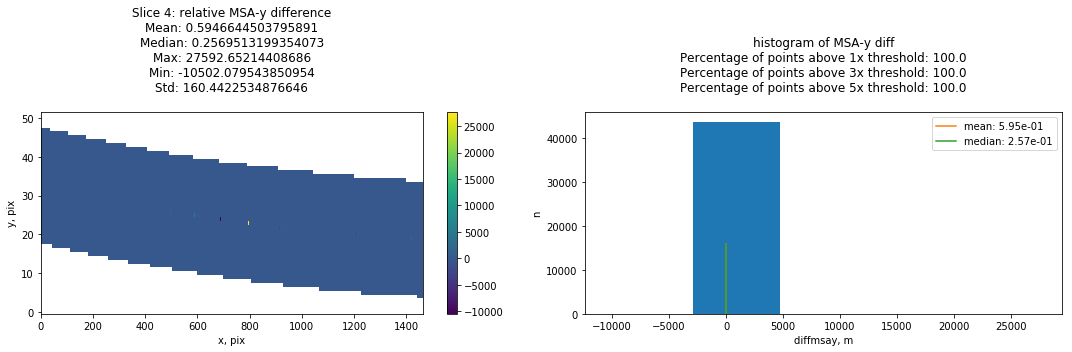

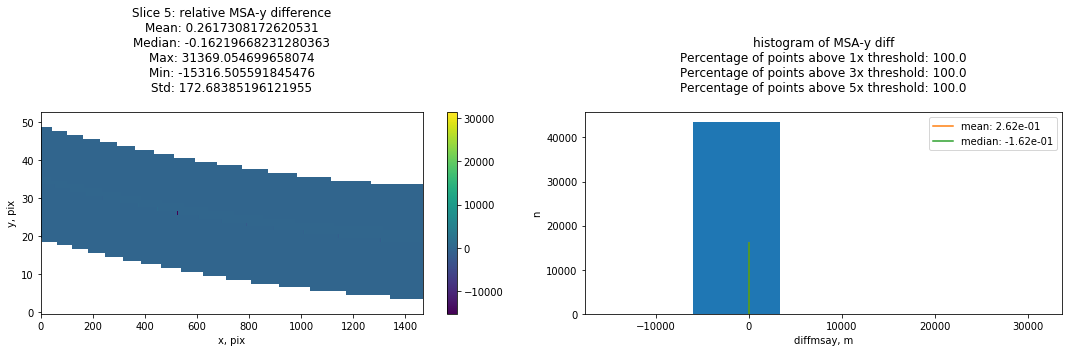

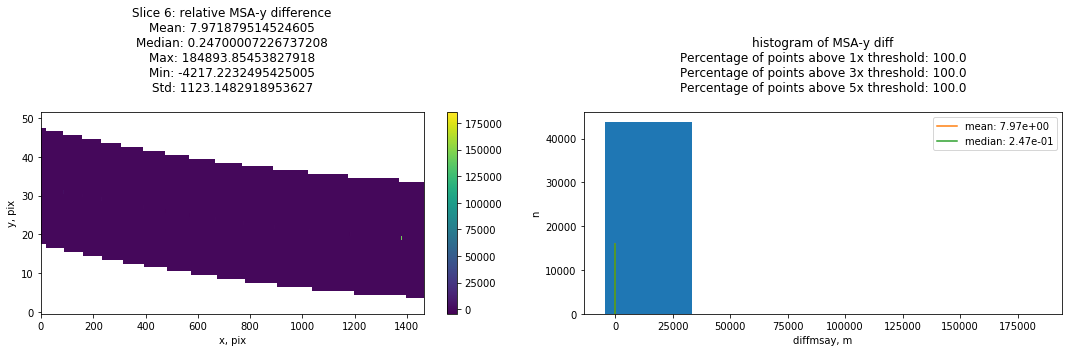

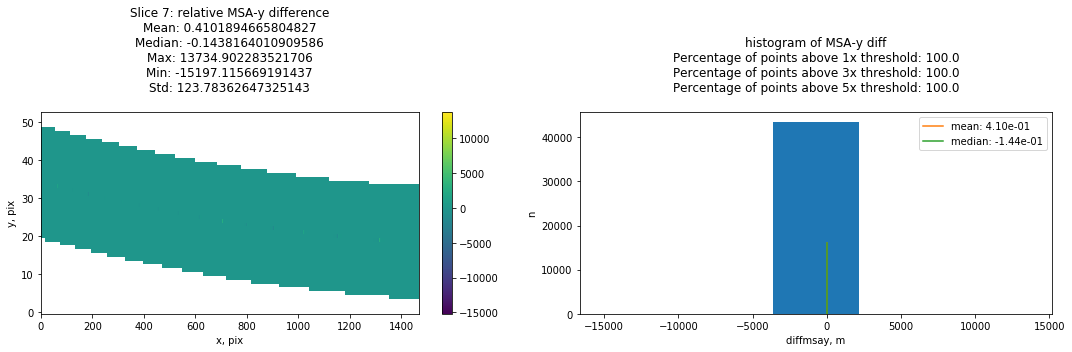

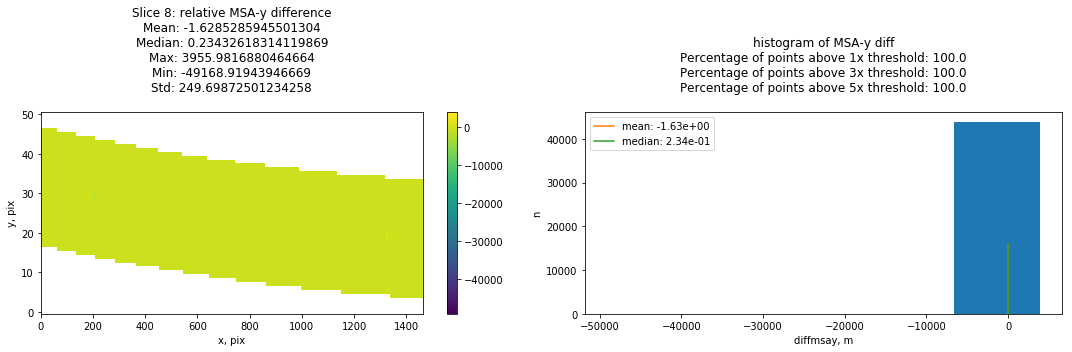

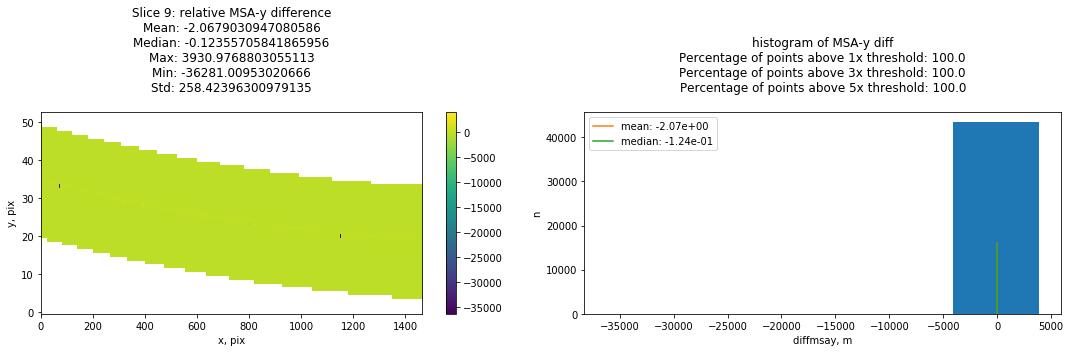

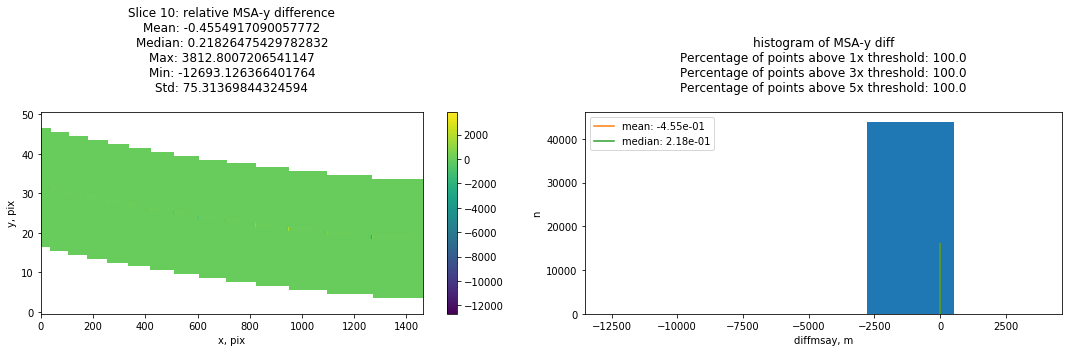

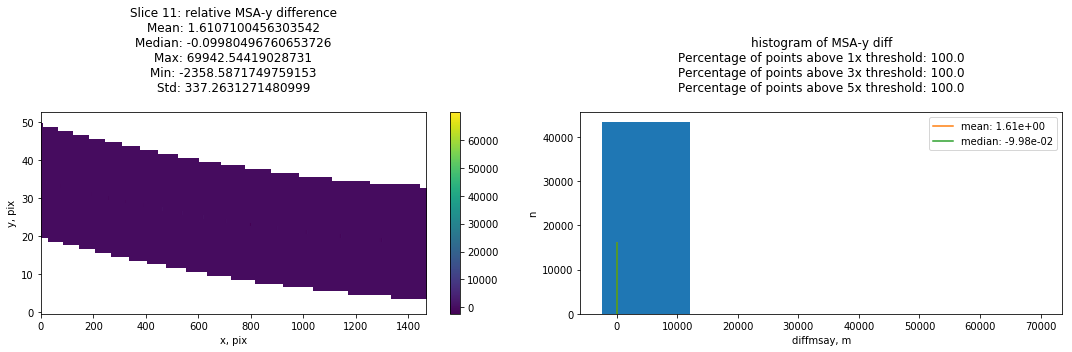

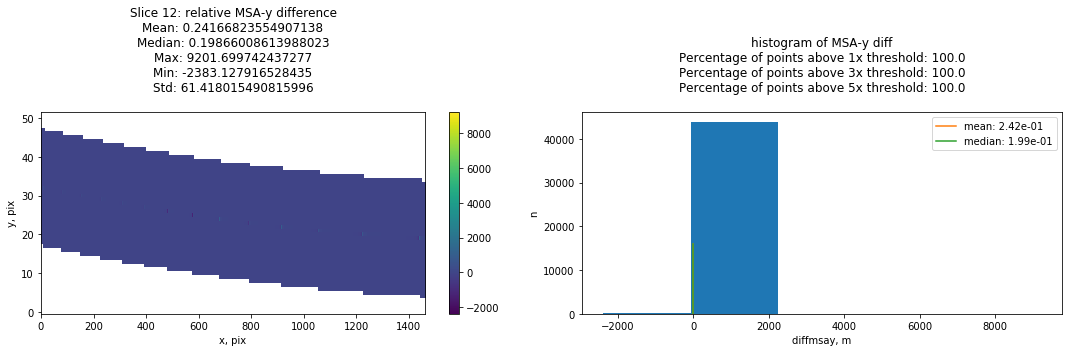

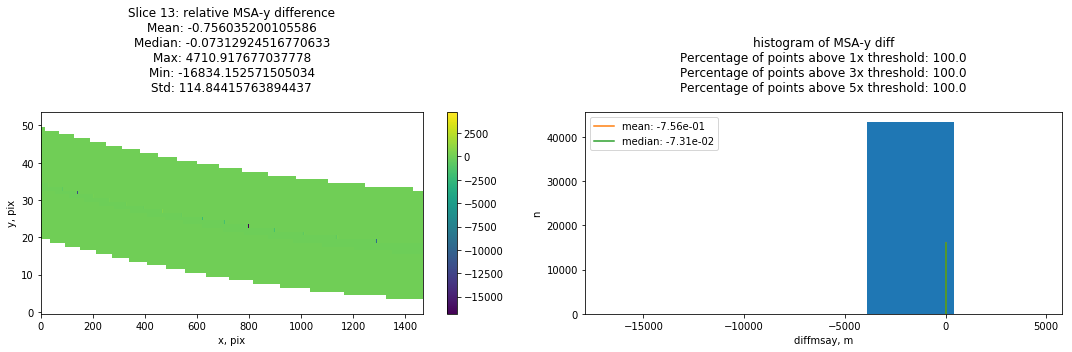

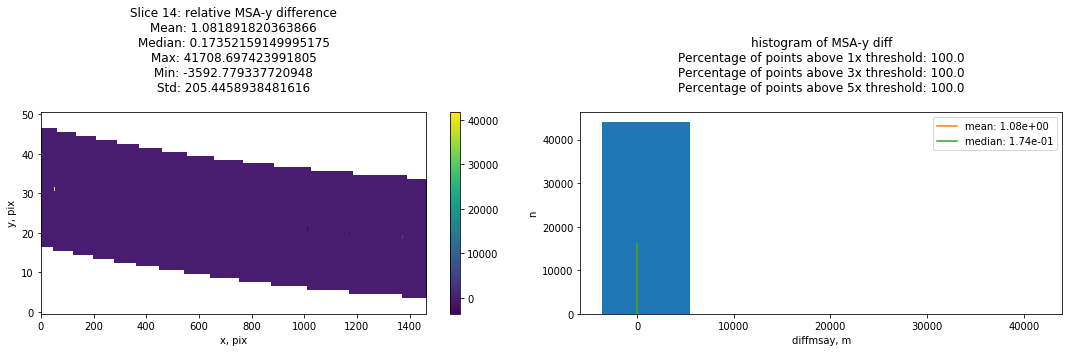

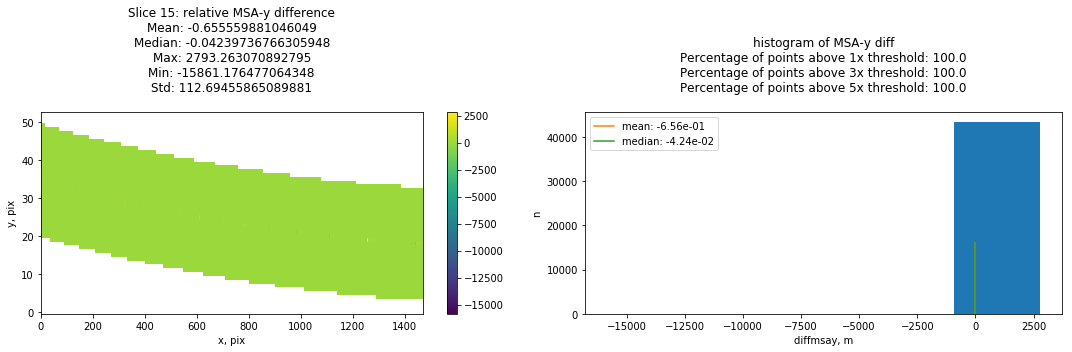

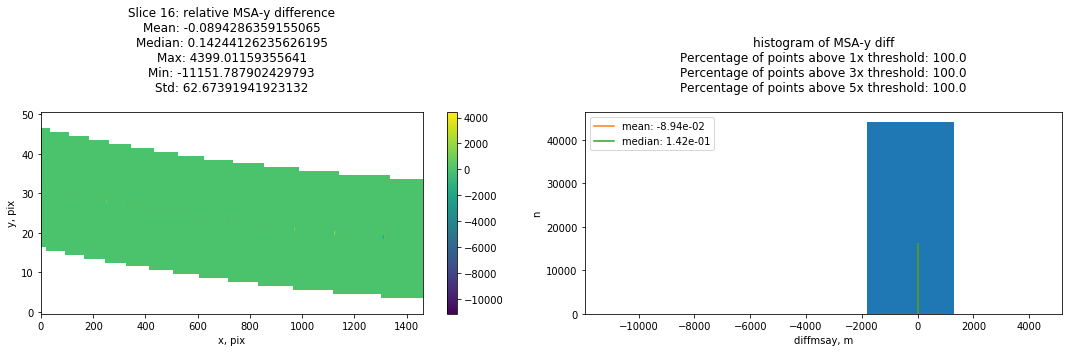

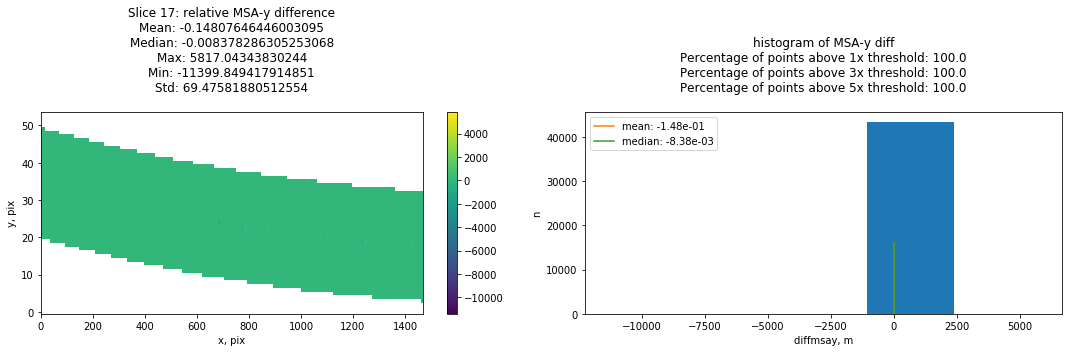

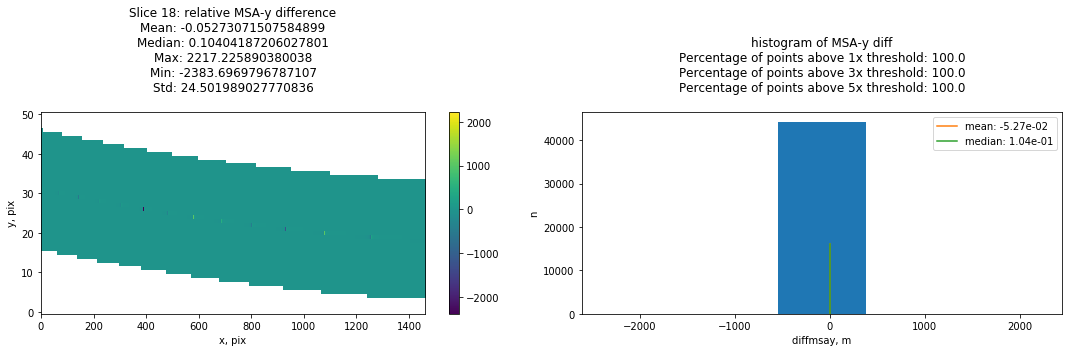

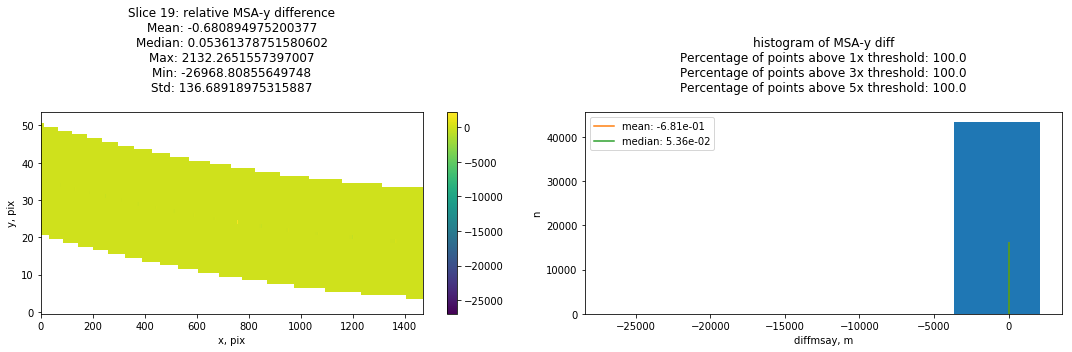

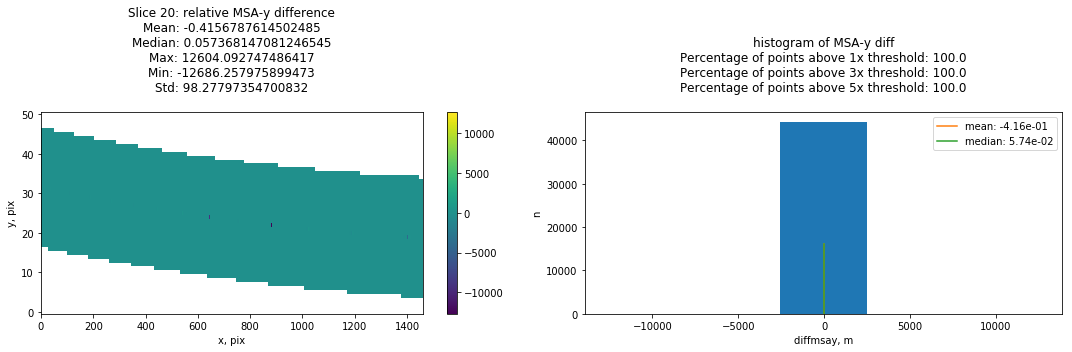

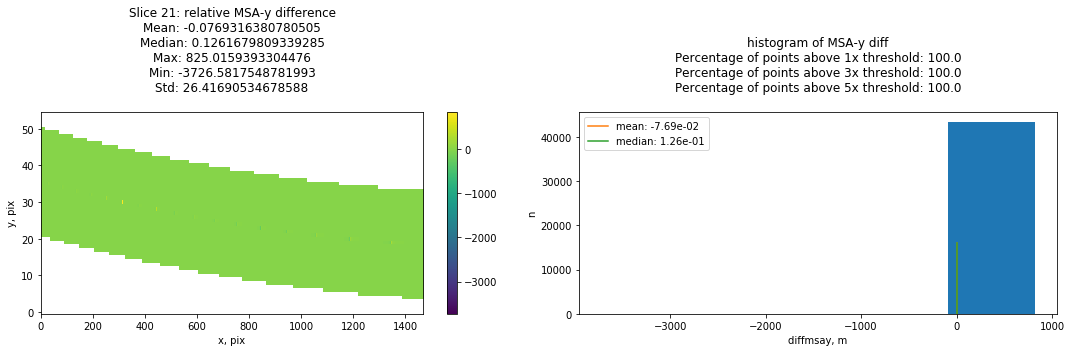

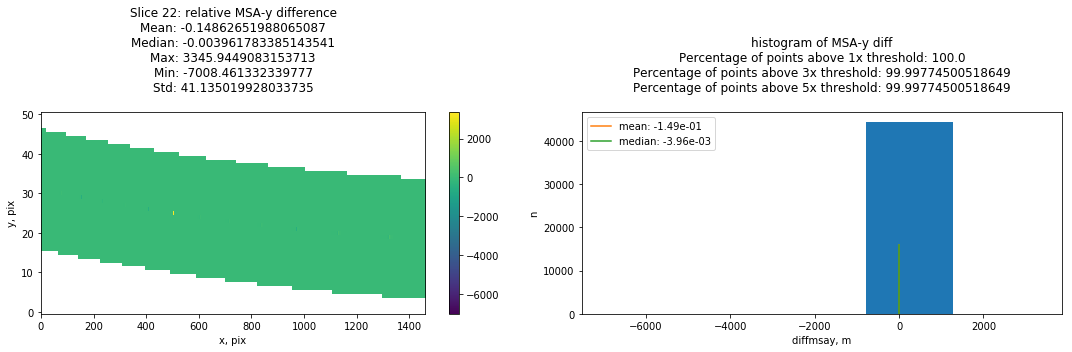

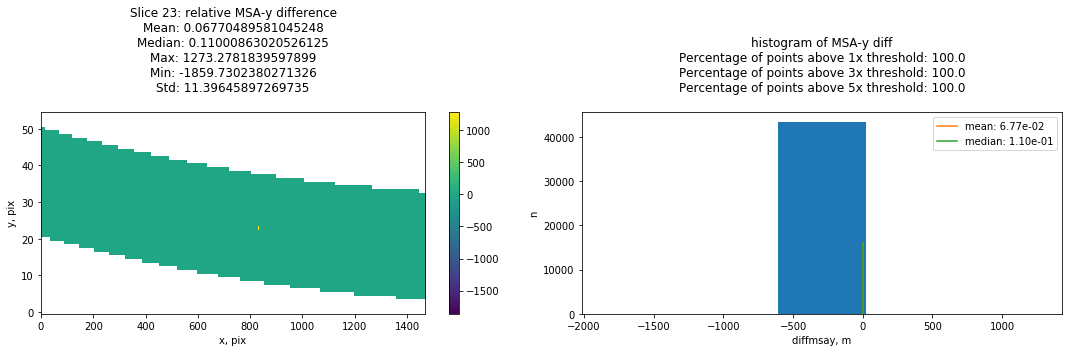

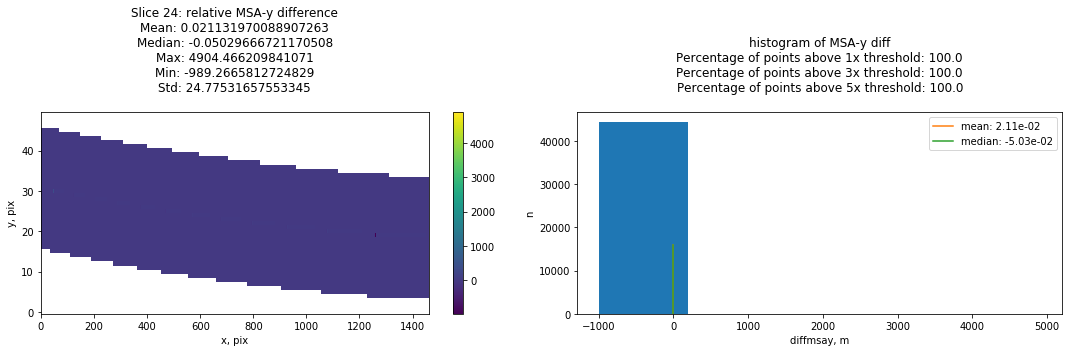

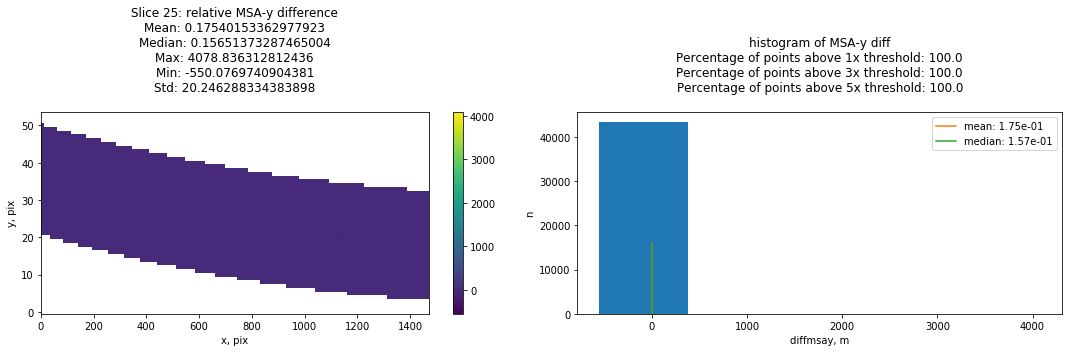

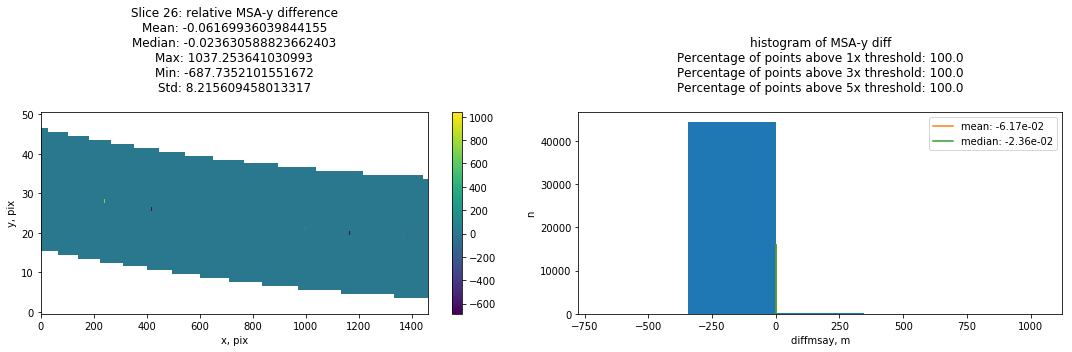

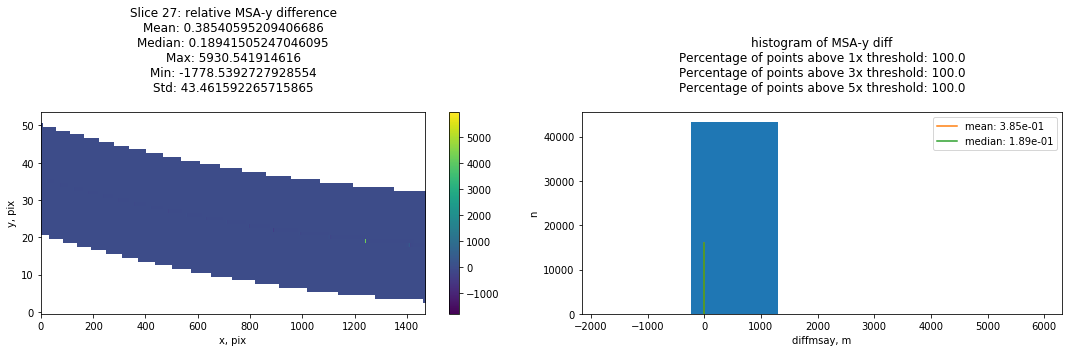

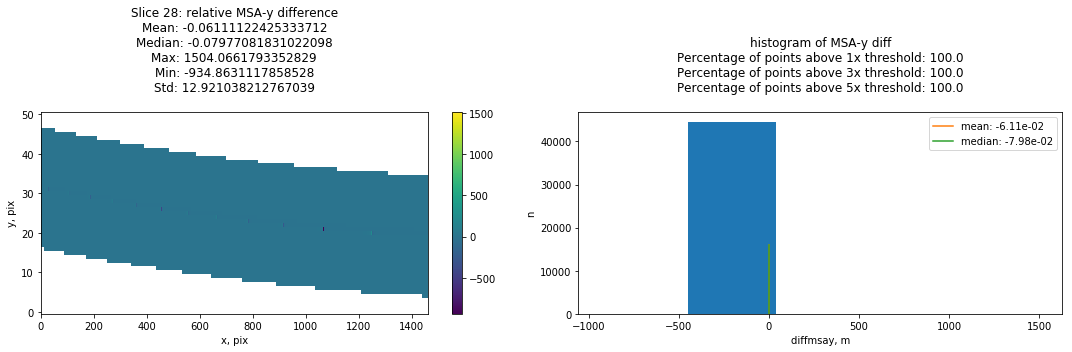

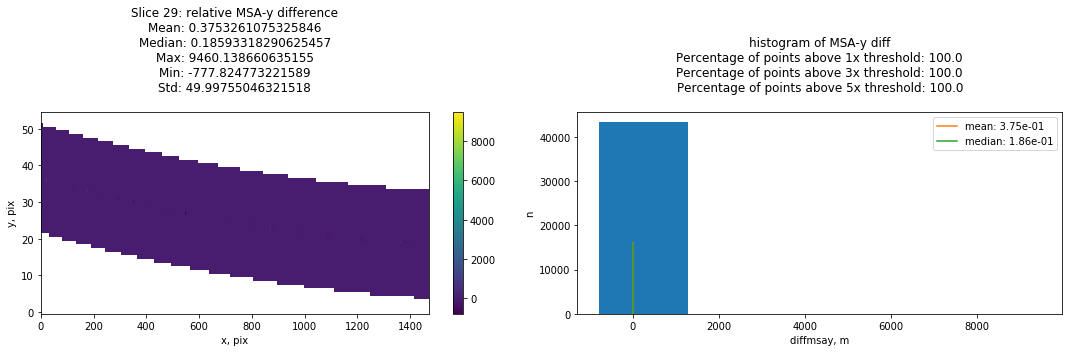

In [11]:
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msay1 = tr['MSAY1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    # Compute the difference in MSA positions
    detector2msa = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2msa(x1-1, y1-1)
    
    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    my[~in_slit] = np.nan
    nanind = np.isnan(my)
    notnan = ~nanind
    
    diffmsay = (my - msay1) / msay1
    percentage_results = compute_percentage(diffmsay, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsay[notnan])
    median = np.median(diffmsay[notnan])
    dmax = np.max(diffmsay[notnan])
    dmin = np.min(diffmsay[notnan])
    dstd = np.std(diffmsay[notnan])

    title1 = "Slice {}: relative MSA-y difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-y diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsay, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsay[~np.isnan(diffmsay)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsay, m')
    plt.ylabel('n')
    fig.tight_layout()

** MSA_x position **

2018-04-28 10:03:12,757 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



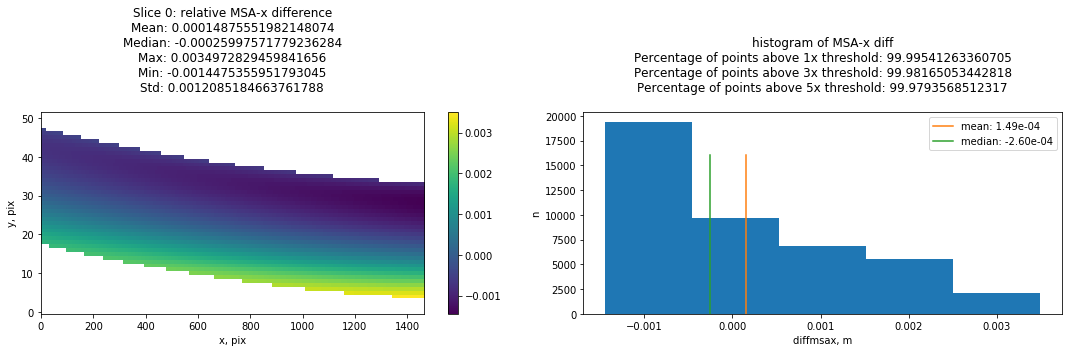

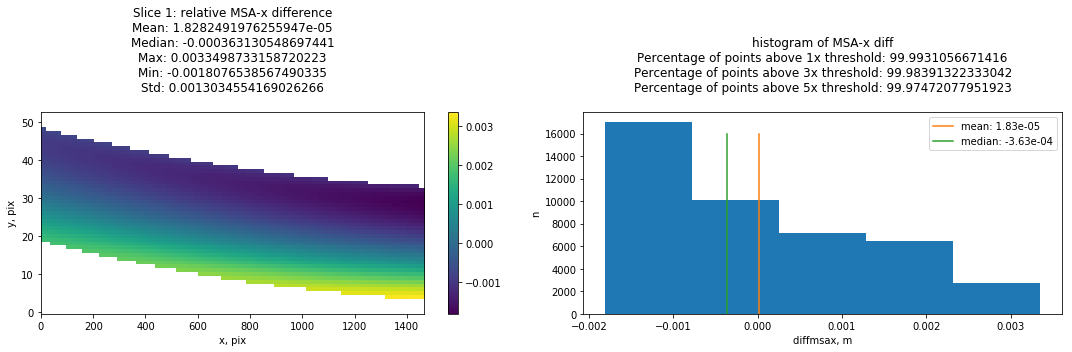

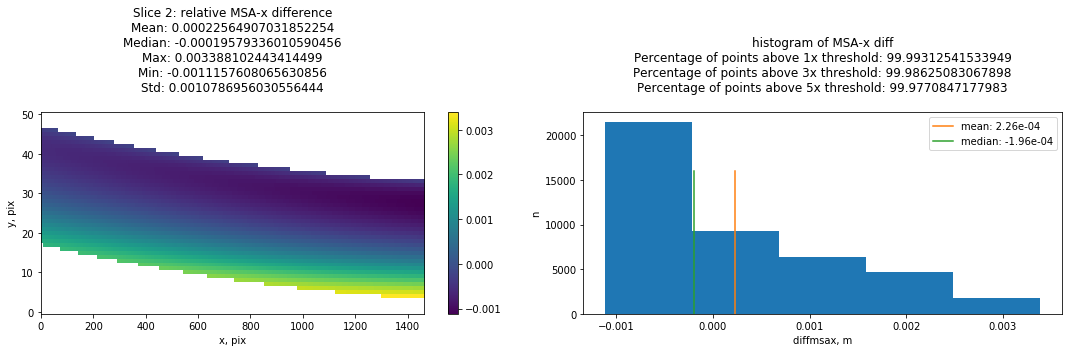

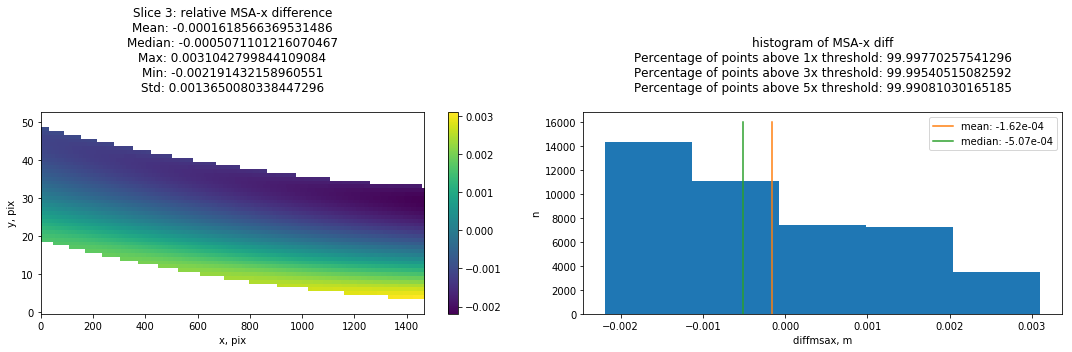

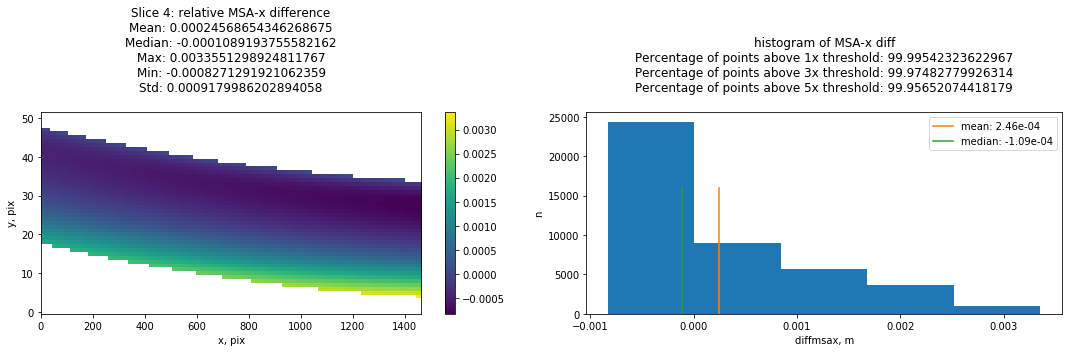

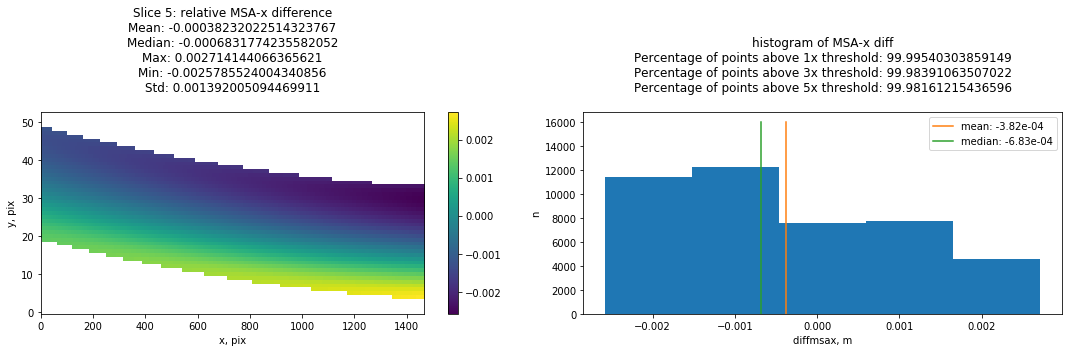

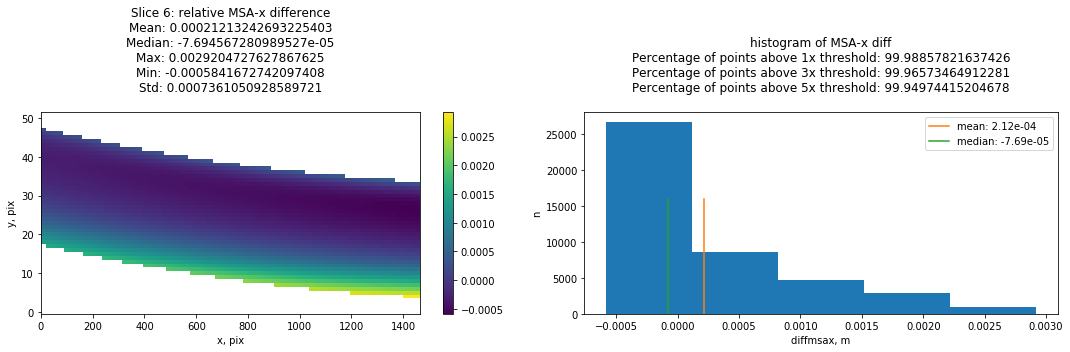

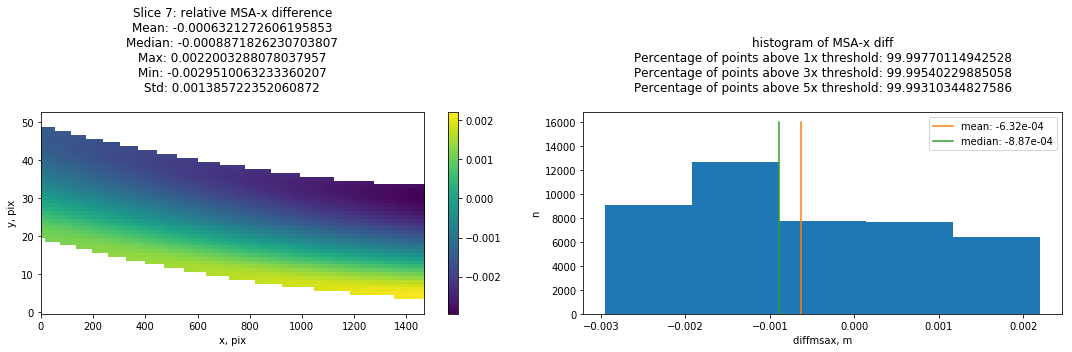

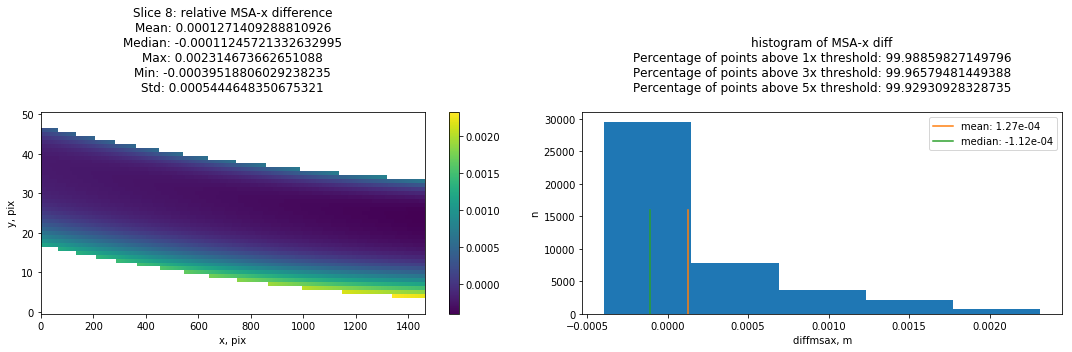

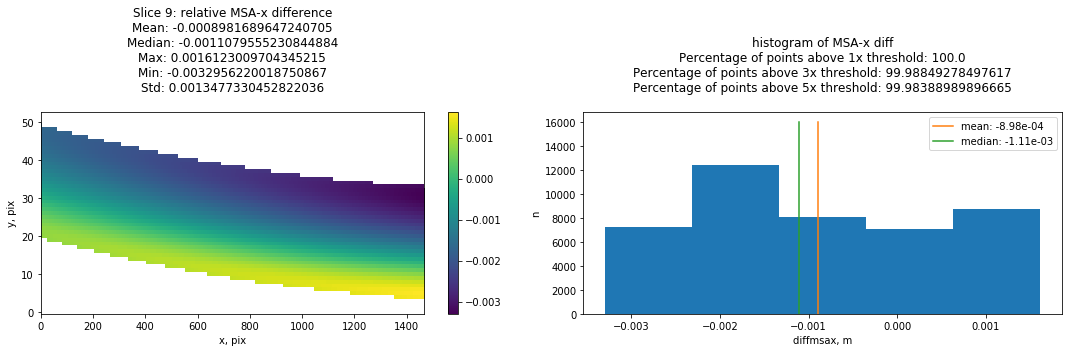

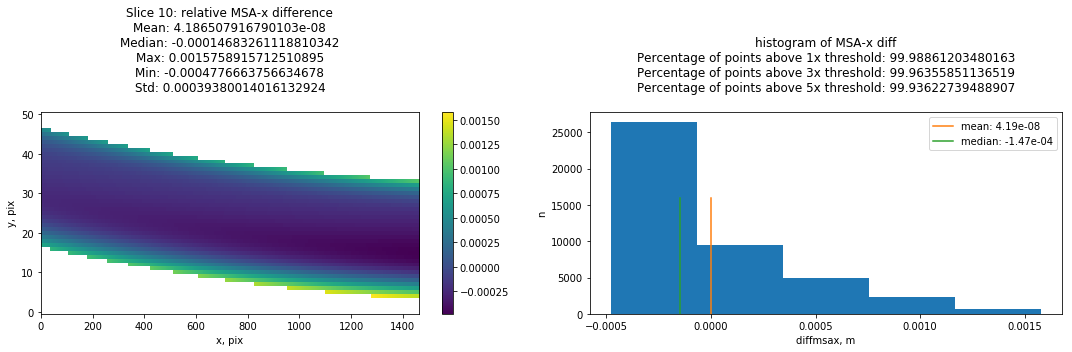

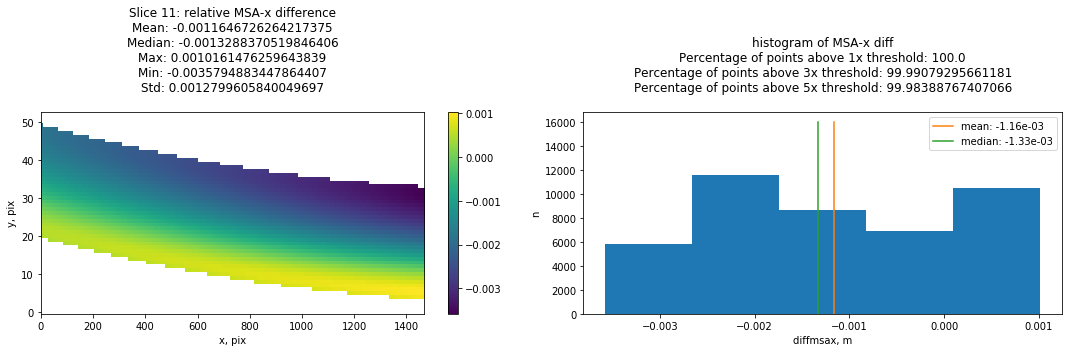

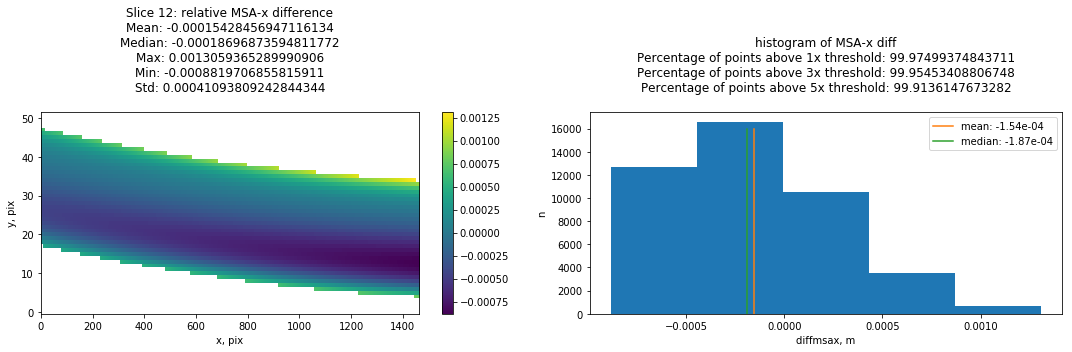

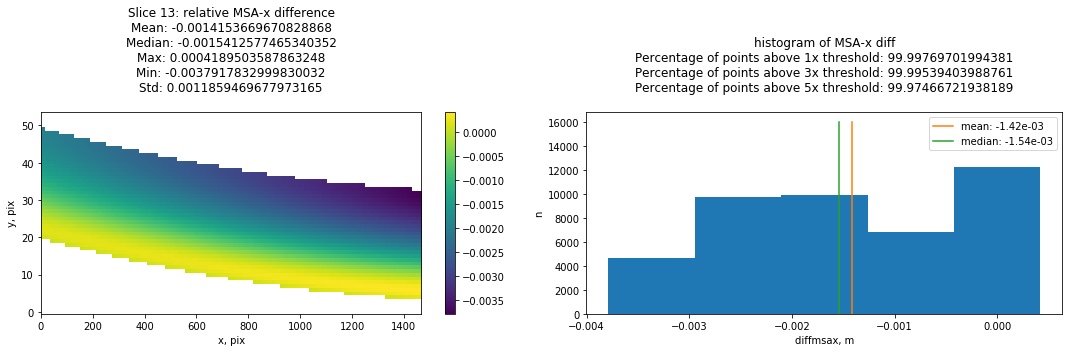

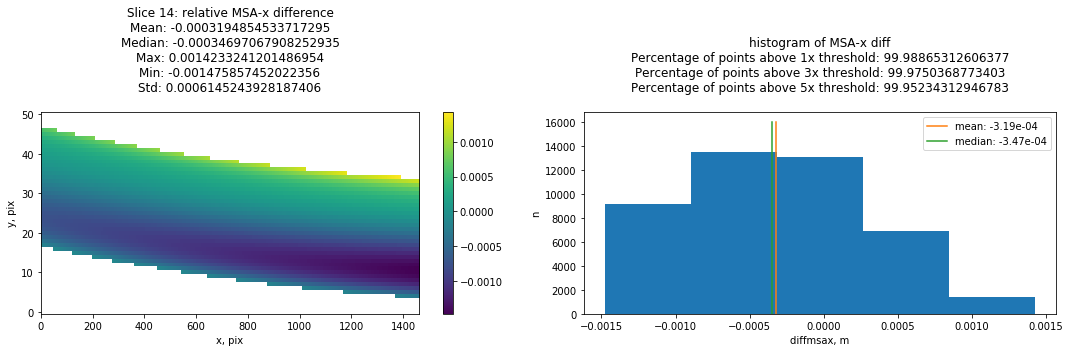

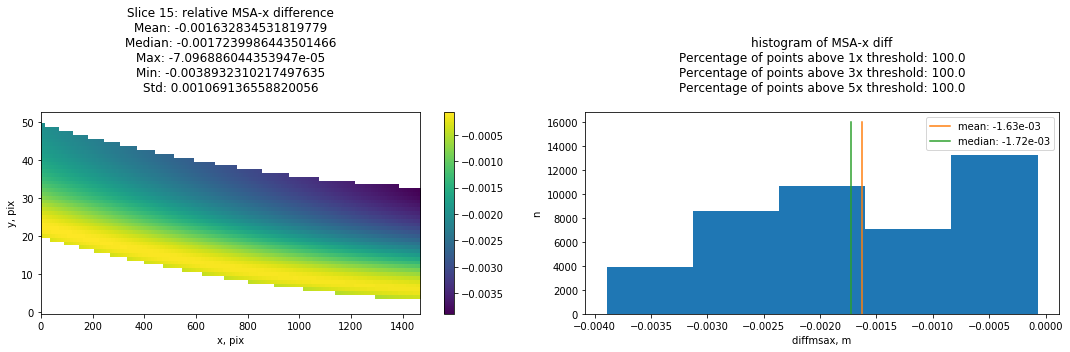

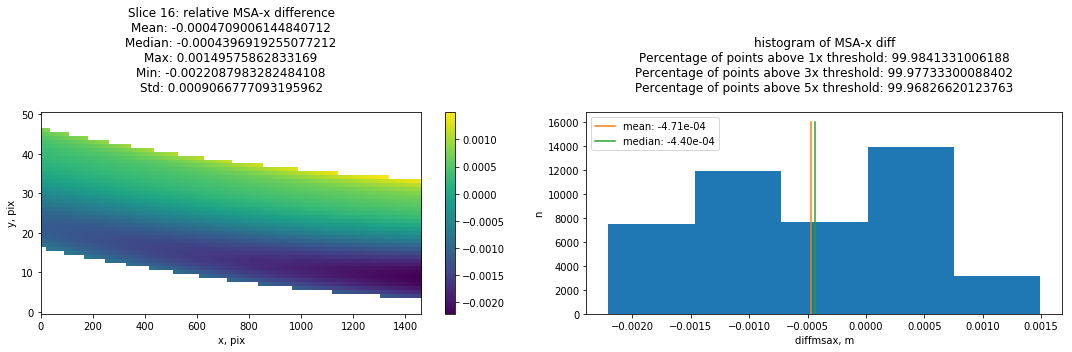

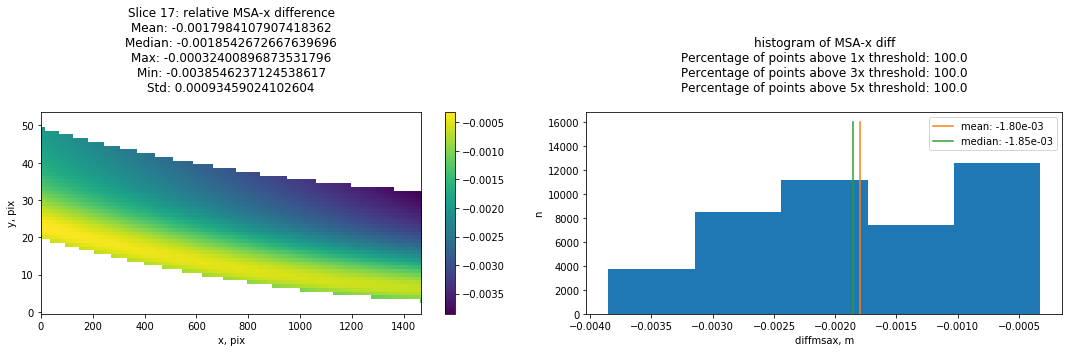

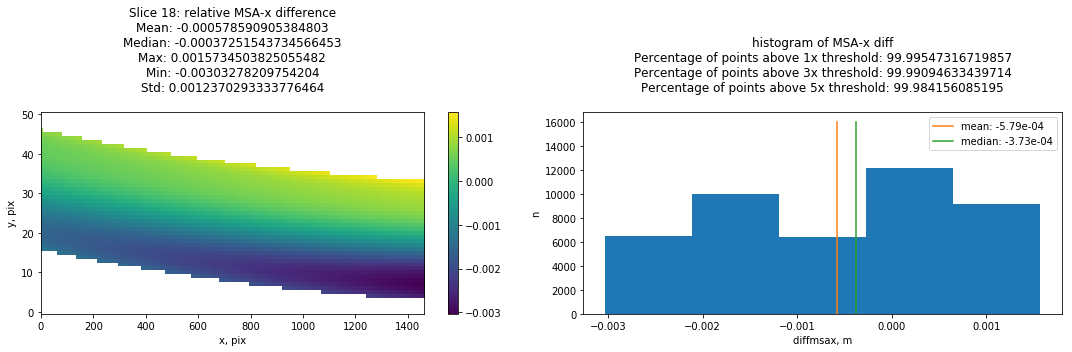

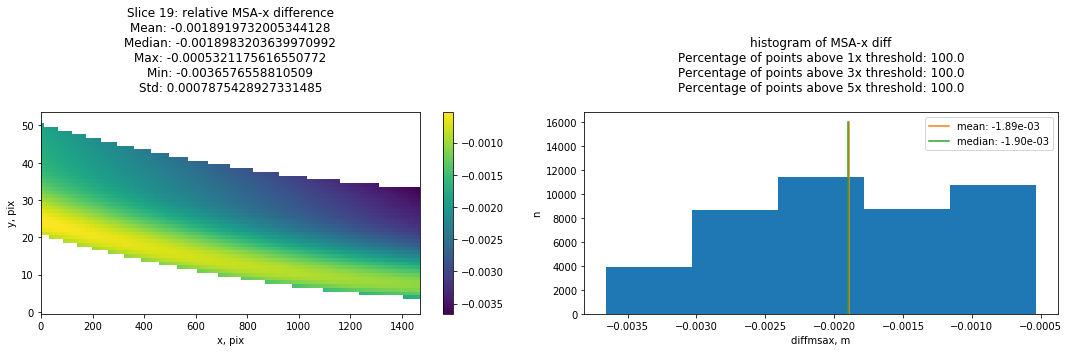

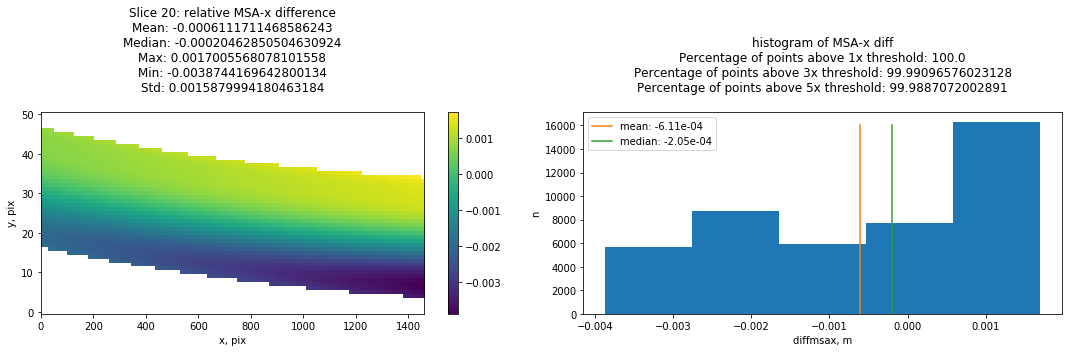

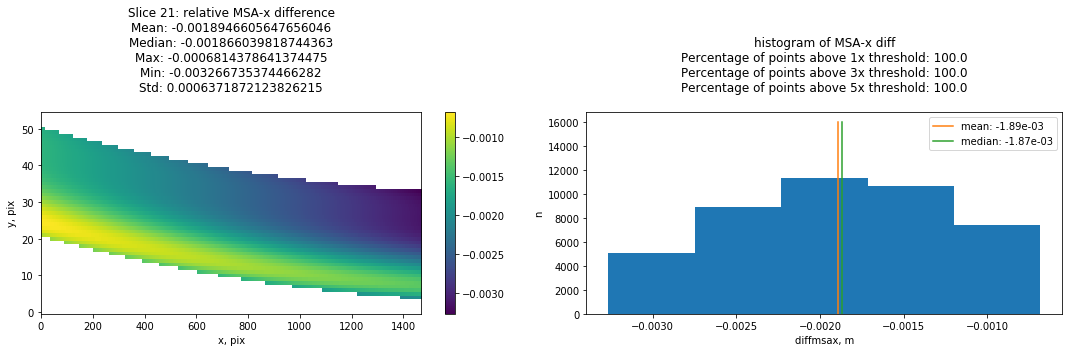

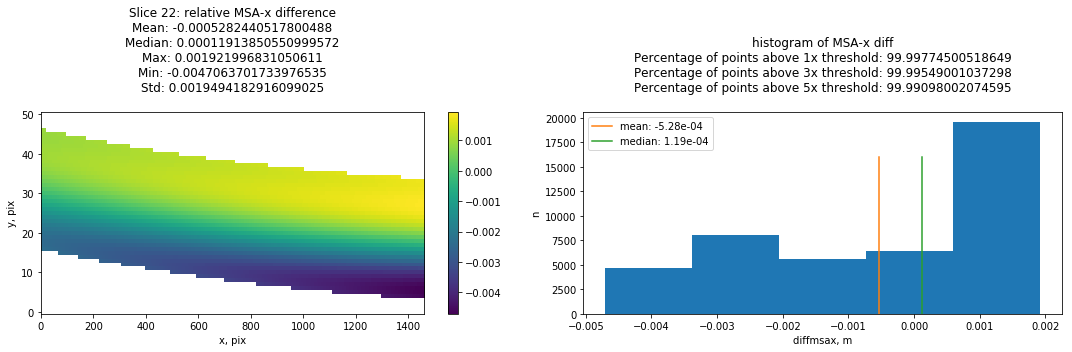

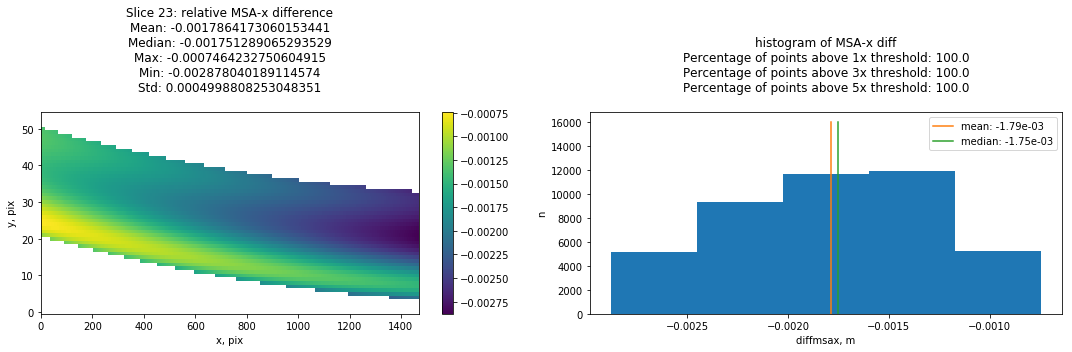

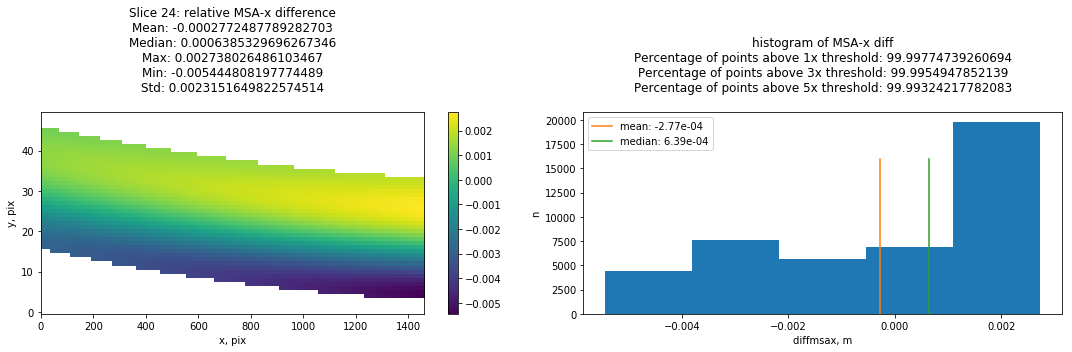

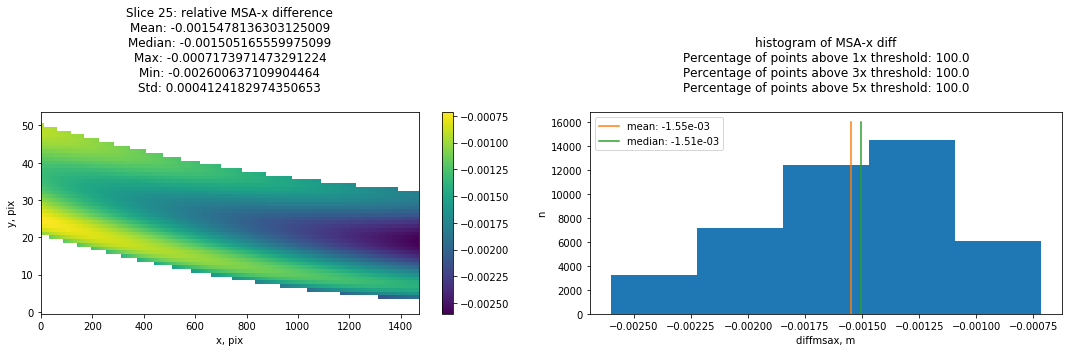

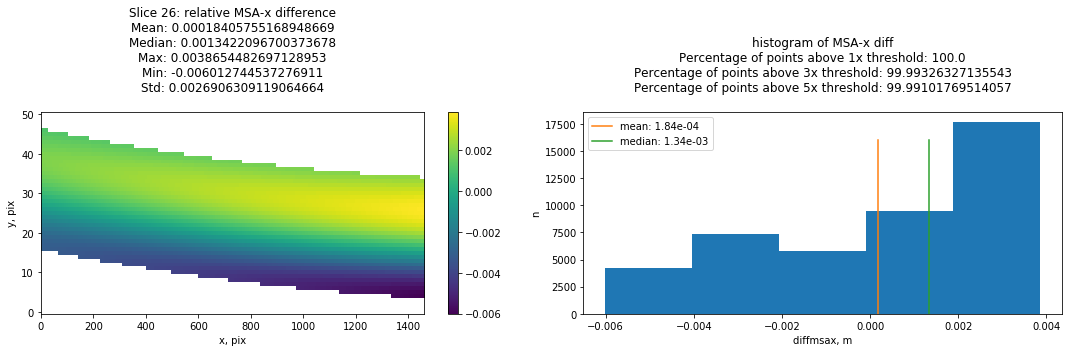

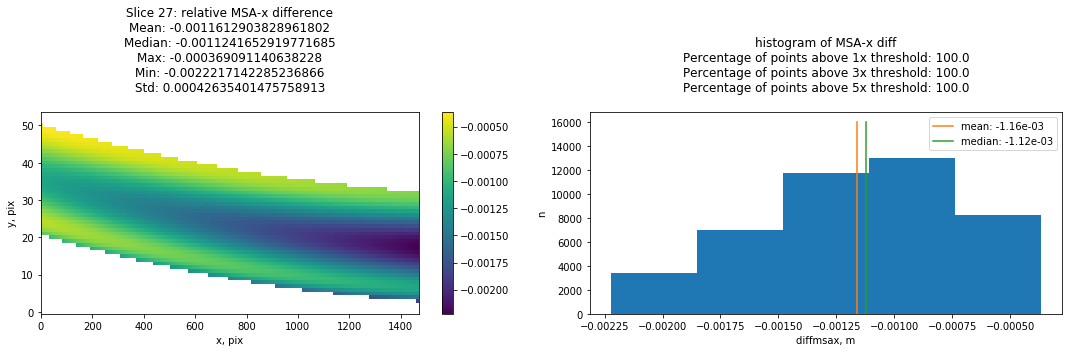

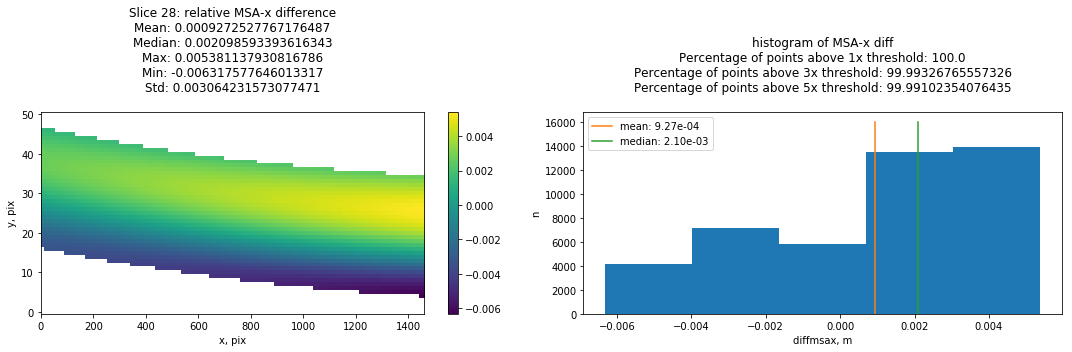

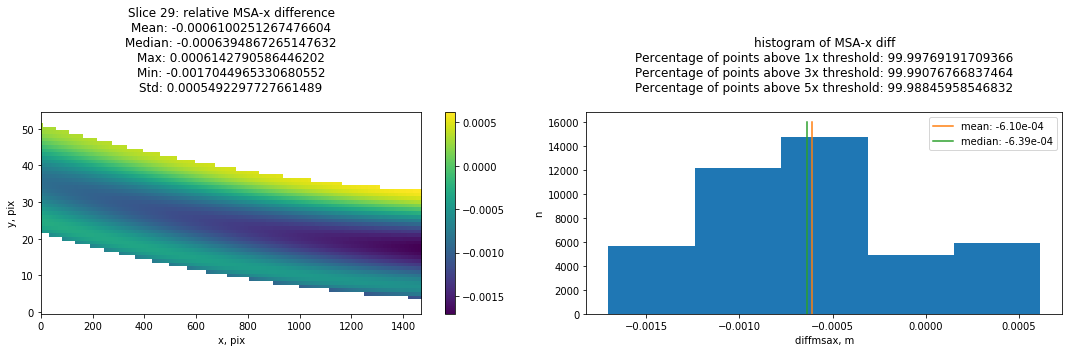

In [12]:
for trace in esa:
    tr = fits.open(trace)
    lam1 = tr['LAMBDA1'].data
    slit1 = tr['SLITY1'].data
    msax1 = tr['MSAX1'].data
    pyw = wcs.WCS(tr['LAMBDA1'].header)
    slice_id = tr[0].header['SLICEID']
    tr.close()

    # Create x, y indices using the Trace WCS
    y, x =np.mgrid[:lam1.shape[0], : lam1.shape[1]]
    x1, y1 = pyw.all_pix2world(x, y, 0)

    # Get the WCS for this particular slice
    wcs_slice = nirspec.nrs_wcs_set_input(im, slice_id)
    
    
    # Compute the difference in MSA positions
    detector2msa = wcs_slice.get_transform("detector", "msa_frame")
    mx, my, lam = detector2msa(x1-1, y1-1)
    
    # Compute indices for slit-y between -.5 and .5
    in_slit = np.logical_and(slit1<.5, slit1>-.5)
    mx[~in_slit] = np.nan
    nanind = np.isnan(mx)
    notnan = ~nanind
    
    diffmsax = (mx - msax1) / msax1
    percentage_results = compute_percentage(diffmsax, 1e-7)
    
    # Compute statistics
    mean = np.mean(diffmsax[notnan])
    median = np.median(diffmsax[notnan])
    dmax = np.max(diffmsax[notnan])
    dmin = np.min(diffmsax[notnan])
    dstd = np.std(diffmsax[notnan])
    
    title1 = "Slice {}: relative MSA-x difference\n".format(slice_id)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of MSA-x diff\n"
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diffmsax, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diffmsax[~np.isnan(diffmsax)].flatten(), bins=5)
    ax2.plot([mean]*2, [0,16000], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,16000], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('diffmsax, m')
    plt.ylabel('n')
    fig.tight_layout()